## Amaury Mario Ribeiro  -  Data Science Challenge

Context and goal:

- improve resource usage by predicting how many days in the month the user will spend in the month.
- (this prediction should be updated continuously throughout the month)

The goal of the exercise is to predict the number of order days for each user in August 2022, even when:

- Some order data is available for certain users,

- Or when no order data is available at all (users with NaN values).

#### Question 1

Predict the remaining orders left for the month for all the users that appear in the file: 'august_with_missing_order_days.parquet'.

### planning

- trainset is the historical_orders
- try to predict with and without TOTAL SALES VARIABLE
- submit a csv file  with all the user in the file  with the columns 'account_id' and 'prediction' without the orders in the prediction. 

## initial exploration and quality data check

I used pandas because it was more efficient at the beginning for initial exploration steps and the data fit in memory, then I used spark for some more complex manipulations, and finally through samples, I returned to pandas for modeling and prediction.

In [47]:
import pandas as pd

In [48]:
df_august_sales = pd.read_parquet('./august_total_sales.parquet')
df_august_sales.sample(5)

,account_id,total_transaction_amount_august
25274,BR_44509812353,11.22
6246,BR_06266382598,25863.62
32699,BR_97527480000185,65364.78
6611,BR_06870721408,1799.94
5257,BR_05206986496,402.30


In [49]:
df_august_order = pd.read_parquet('./august_with_missing_order_days.parquet')
df_august_order.sample(5)

,account_id,order_date,transaction_amount
77471,BR_13104512000140,2022-08-22,206.44
224813,BR_00664962840,2022-08-08,12.62
295689,BR_04867653187,2022-08-03,207.76
89185,BR_92721028391,2022-08-02,53.88
155817,BR_11579707700,2022-08-10,29.53


In [50]:
df_historical = pd.read_parquet('./historical_orders.parquet')
df_historical.sample(5)

,account_id,order_date,transaction_amount
6823878,BR_12767382000162,2021-10-27,-99.00
3023792,BR_04872924000139,2021-10-25,114.54
9024032,BR_02112158562,2022-05-13,52.68
823924,BR_10916601234,2021-02-08,48.60
1211208,BR_90159225272,2021-08-31,58.08


### clean and check data quality

In [51]:
df_august_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          317735 non-null  object 
 1   order_date          304297 non-null  object 
 2   transaction_amount  304297 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [52]:
df_august_order.isna().sum()

account_id                0
order_date            13438
transaction_amount    13438
dtype: int64

In [53]:
df_august_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_amount_august  32944 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [54]:
df_august_sales.isna().sum()

account_id                         0
total_transaction_amount_august    0
dtype: int64

In [55]:
df_historical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB


In [56]:
df_historical.isna().sum()

account_id            0
order_date            0
transaction_amount    0
dtype: int64

In [57]:
df_august_order['order_date'].unique()

array(['2022-08-03', '2022-08-04', '2022-08-08', '2022-08-09',
       '2022-08-11', '2022-08-02', '2022-08-05', '2022-08-06',
       '2022-08-10', '2022-08-12', '2022-08-13', '2022-08-15',
       '2022-08-16', '2022-08-17', '2022-08-18', None, '2022-08-19',
       '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-01',
       '2022-08-22', '2022-08-30', '2022-08-29', '2022-08-20',
       '2022-08-27', '2022-08-21', '2022-08-26', '2022-08-14',
       '2022-08-07', '2022-08-28'], dtype=object)

In [58]:
df_august_order['order_date'] = pd.to_datetime(df_august_order['order_date'], format='%Y-%m-%d', errors='raise')

In [59]:
df_historical['order_date'] = pd.to_datetime(df_historical['order_date'], format='%Y-%m-%d', errors='raise')

In [60]:
import seaborn as sns

In [61]:
## checking the range of the dates, if there is any date outside of august for example
df_august_order['order_date'].max(), df_august_order['order_date'].min() 

(Timestamp('2022-08-30 00:00:00'), Timestamp('2022-08-01 00:00:00'))

In [62]:
 # the base has already had the temporal separation, there was no leak of information from August in the historical base
df_historical['order_date'].max(), df_historical['order_date'].min()

(Timestamp('2022-07-31 00:00:00'), Timestamp('2021-01-02 00:00:00'))

In [63]:
df_august_order['transaction_amount'].describe()

count    304297.000000
mean        281.339536
std        1251.632794
min         -99.000000
25%          34.930000
50%          84.000000
75%         205.250000
max      171325.440000
Name: transaction_amount, dtype: float64

In [64]:
df_august_order[df_august_order['transaction_amount'] < 0].count()/ df_august_order.count() * 100   #0.07% de negatives

account_id            0.073332
order_date            0.076570
transaction_amount    0.076570
dtype: float64

In [65]:
df_august_sales['total_transaction_amount_august'].describe()

count    3.294400e+04
mean     6.413068e+03
std      3.953953e+04
min     -9.108000e+03
25%      5.700300e+02
50%      1.638605e+03
75%      4.558312e+03
max      2.638720e+06
Name: total_transaction_amount_august, dtype: float64

In [66]:
df_august_sales[df_august_sales['total_transaction_amount_august'] < 0].count() / df_august_sales.count() * 100  #0.5% negatives

account_id                         0.50085
total_transaction_amount_august    0.50085
dtype: float64

In [67]:
df_historical[df_historical['transaction_amount'] < 0].count()/ df_historical.count() * 100   #1.1% de negatives

account_id            1.106576
order_date            1.106576
transaction_amount    1.106576
dtype: float64

founded a small number (<0.5%) of negative values in monetary columns (`transaction_amount`, `total_transaction_amount_august`).  
As negative values do not make sense in this context and likely represent data issues, I will fill with nulls ( because it is not possible to infer the correct value without knowing the problem in detail, and I cannot delete it so as not to lose order records. Also, replacing it with another value can distort features)


In [68]:
import numpy as np

In [69]:
df_august_sales.loc[df_august_sales['total_transaction_amount_august'] < 0, 'total_transaction_amount_august'] = np.nan

In [70]:
df_historical.loc[df_historical['transaction_amount'] < 0, 'transaction_amount'] = np.nan

In [71]:
df_august_order.loc[df_august_order['transaction_amount'] < 0, 'transaction_amount'] = np.nan

In [72]:
df_historical['account_id'].nunique(), df_august_order['account_id'].nunique(),  df_august_sales['account_id'].nunique()

(47899, 32944, 32944)

In [73]:
df_join_comum = (
    pd.merge(
        df_historical[['account_id']].drop_duplicates(), 
        df_august_order[['account_id']].drop_duplicates(), 
        on='account_id',
        how='outer',
        indicator=True
    )
)

In [74]:
df_join_comum['_merge'].value_counts()

_merge
both          31721
left_only     16178
right_only     1223
Name: count, dtype: int64

Users were found in both the historical data and the August sales. There are two possible approaches: one is to use all available users; the other is to apply a group-based split to ensure that the same clients are not included in both the training and test datasets.

In [75]:
(
    pd.merge(
        df_august_sales[['account_id']].drop_duplicates(), 
        df_august_order[['account_id']].drop_duplicates(), 
        on='account_id',
        how='outer',
        indicator=True
    )['_merge'].value_counts()
)

_merge
both          32944
left_only         0
right_only        0
Name: count, dtype: int64

##  creating the target

joining both to create the features, then I will separate them after using the date

In [76]:
df_august_order_missing = df_august_order[df_august_order['order_date'].isna()].copy()

In [96]:
df_august_order_missing['transaction_amount'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: transaction_amount, dtype: float64

In [77]:
df_august_order_not_missing = df_august_order[~ df_august_order['order_date'].isna()].copy()

In [78]:
df_historical = pd.concat([df_historical, df_august_order_not_missing], ignore_index=True)

In [79]:
df_historical['order_day'] = df_historical['order_date'].dt.date ## auxiliary

In [80]:
df_historical['order_month'] = df_historical['order_date'].dt.to_period('M')

In [81]:
df_historical[df_historical['account_id'] == 'BR_99980878134'].sample(5)

,account_id,order_date,transaction_amount,order_day,order_month
2309606,BR_99980878134,2021-06-10,16.98,2021-06-10,2021-06
2314605,BR_99980878134,2021-05-25,25.10,2021-05-25,2021-05
5771156,BR_99980878134,2021-05-18,25.10,2021-05-18,2021-05
5771162,BR_99980878134,2021-05-18,19.98,2021-05-18,2021-05
124326,BR_99980878134,2021-05-29,24.76,2021-05-29,2021-05


As the model needs to learn the days when there were no orders, I need to map all the dates within the period

In [82]:
start_date = df_historical['order_day'].min().replace(day=1)
end_date = df_historical['order_day'].max().replace(day=1) + pd.offsets.MonthEnd(1)
start_date, end_date

(datetime.date(2021, 1, 1), Timestamp('2022-08-31 00:00:00'))

In [83]:
all_days = pd.date_range(start=start_date, end=end_date, freq='D')
all_days

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
               '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
               '2022-08-30', '2022-08-31'],
              dtype='datetime64[ns]', length=608, freq='D')

In [84]:
df_days = pd.DataFrame({'current_day': all_days})
df_days['order_month'] = df_days['current_day'].dt.to_period('M')
df_days.sample(5)

,current_day,order_month
424,2022-03-01,2022-03
391,2022-01-27,2022-01
212,2021-08-01,2021-08
393,2022-01-29,2022-01
363,2021-12-30,2021-12


In [85]:
users_months = df_historical[['account_id', 'order_month']].drop_duplicates()
df_user_days = users_months.merge(df_days, on='order_month', how='left')
df_user_days

,account_id,order_month,current_day
0,BR_09607801000194,2021-08,2021-08-01
1,BR_09607801000194,2021-08,2021-08-02
2,BR_09607801000194,2021-08,2021-08-03
3,BR_09607801000194,2021-08,2021-08-04
4,BR_09607801000194,2021-08,2021-08-05
...,...,...,...
13270982,BR_20172361000122,2022-08,2022-08-27
13270983,BR_20172361000122,2022-08,2022-08-28
13270984,BR_20172361000122,2022-08,2022-08-29
13270985,BR_20172361000122,2022-08,2022-08-30


In [86]:
df_orders_aux = df_historical[['account_id', 'order_day', 'order_month']].drop_duplicates()
df_orders_aux['has_order'] = 1  ## dates with orders

In [87]:
df_user_days['order_day'] = df_user_days['current_day'].dt.date
df_user_days = df_user_days.merge(
    df_orders_aux, on=['account_id', 'order_day', 'order_month'], how='left'
)
df_user_days

,account_id,order_month,current_day,order_day,has_order
0,BR_09607801000194,2021-08,2021-08-01,2021-08-01,NaN
1,BR_09607801000194,2021-08,2021-08-02,2021-08-02,NaN
2,BR_09607801000194,2021-08,2021-08-03,2021-08-03,NaN
3,BR_09607801000194,2021-08,2021-08-04,2021-08-04,NaN
4,BR_09607801000194,2021-08,2021-08-05,2021-08-05,1.0
...,...,...,...,...,...
13270982,BR_20172361000122,2022-08,2022-08-27,2022-08-27,NaN
13270983,BR_20172361000122,2022-08,2022-08-28,2022-08-28,NaN
13270984,BR_20172361000122,2022-08,2022-08-29,2022-08-29,NaN
13270985,BR_20172361000122,2022-08,2022-08-30,2022-08-30,NaN


In [88]:
df_user_days['has_order'] = df_user_days['has_order'].fillna(0)
df_user_days.sample(5)

,account_id,order_month,current_day,order_day,has_order
5801010,BR_15205525215,2021-11,2021-11-16,2021-11-16,0.0
12899962,BR_70713482273,2022-08,2022-08-15,2022-08-15,0.0
6465901,BR_11033598941,2021-06,2021-06-22,2021-06-22,0.0
2908911,BR_09182217000134,2022-01,2022-01-27,2022-01-27,0.0
2285109,BR_89418479000194,2021-02,2021-02-14,2021-02-14,0.0


In [89]:
from datetime import datetime

# generate august days
aug_start = pd.Timestamp('2022-08-01')
aug_end = pd.Timestamp('2022-08-31')
all_august_days = pd.date_range(start=aug_start, end=aug_end, freq='D')

df_august_days = pd.DataFrame({'current_day': all_august_days})
df_august_days['order_month'] = df_august_days['current_day'].dt.to_period('M')
df_august_days['order_day'] = df_august_days['current_day'].dt.date
df_august_days.head(6)

,current_day,order_month,order_day
0,2022-08-01,2022-08,2022-08-01
1,2022-08-02,2022-08,2022-08-02
2,2022-08-03,2022-08,2022-08-03
3,2022-08-04,2022-08,2022-08-04
4,2022-08-05,2022-08,2022-08-05
5,2022-08-06,2022-08,2022-08-06


In [90]:
df_august_users = df_august_order_missing[['account_id']].drop_duplicates()

df_august_empty = df_august_users.merge(df_august_days, how='cross')
df_august_empty['has_order'] = 0

In [92]:
df_user_days = pd.concat([df_user_days, df_august_empty], ignore_index=True)
df_user_days

,account_id,order_month,current_day,order_day,has_order
0,BR_09607801000194,2021-08,2021-08-01,2021-08-01,0.0
1,BR_09607801000194,2021-08,2021-08-02,2021-08-02,0.0
2,BR_09607801000194,2021-08,2021-08-03,2021-08-03,0.0
3,BR_09607801000194,2021-08,2021-08-04,2021-08-04,0.0
4,BR_09607801000194,2021-08,2021-08-05,2021-08-05,1.0
...,...,...,...,...,...
13687560,BR_82856567649,2022-08,2022-08-27,2022-08-27,0.0
13687561,BR_82856567649,2022-08,2022-08-28,2022-08-28,0.0
13687562,BR_82856567649,2022-08,2022-08-29,2022-08-29,0.0
13687563,BR_82856567649,2022-08,2022-08-30,2022-08-30,0.0


In [93]:
# first group the data by account_id and order_month to isolate 
# reverse the has_order series (which is 1 for days with orders and 0 for all other days), so that I can count orders from the end of the month toward the beginning.
# apply cumsum() to the reversed series. This gives me, for each day, the number of days with orders from that point until the end of the month.
# reverse the cumulative series again, so that the values ​​align with the chronological order of the days in the month.

df_user_days['order_days_remaining'] = (
    df_user_days
    .groupby(['account_id', 'order_month'])['has_order']
    .transform(lambda x: x[::-1].cumsum()[::-1])  - df_user_days['has_order'] #subtracting the day so as not to take it into account
)
df_user_days

,account_id,order_month,current_day,order_day,has_order,order_days_remaining
0,BR_09607801000194,2021-08,2021-08-01,2021-08-01,0.0,5.0
1,BR_09607801000194,2021-08,2021-08-02,2021-08-02,0.0,5.0
2,BR_09607801000194,2021-08,2021-08-03,2021-08-03,0.0,5.0
3,BR_09607801000194,2021-08,2021-08-04,2021-08-04,0.0,5.0
4,BR_09607801000194,2021-08,2021-08-05,2021-08-05,1.0,4.0
...,...,...,...,...,...,...
13687560,BR_82856567649,2022-08,2022-08-27,2022-08-27,0.0,0.0
13687561,BR_82856567649,2022-08,2022-08-28,2022-08-28,0.0,0.0
13687562,BR_82856567649,2022-08,2022-08-29,2022-08-29,0.0,0.0
13687563,BR_82856567649,2022-08,2022-08-30,2022-08-30,0.0,0.0


In [94]:
df_historical[ (df_historical['account_id'] == 'BR_99980878134')  & (df_historical['order_month'] == '2021-05')]

,account_id,order_date,transaction_amount,order_day,order_month
124219,BR_99980878134,2021-05-29,28.90,2021-05-29,2021-05
124326,BR_99980878134,2021-05-29,24.76,2021-05-29,2021-05
2314605,BR_99980878134,2021-05-25,25.10,2021-05-25,2021-05
2322922,BR_99980878134,2021-05-29,30.00,2021-05-29,2021-05
2323037,BR_99980878134,2021-05-29,76.36,2021-05-29,2021-05
5771150,BR_99980878134,2021-05-18,38.18,2021-05-18,2021-05
5771156,BR_99980878134,2021-05-18,25.10,2021-05-18,2021-05
5771157,BR_99980878134,2021-05-18,26.90,2021-05-18,2021-05
5771162,BR_99980878134,2021-05-18,19.98,2021-05-18,2021-05
5771163,BR_99980878134,2021-05-18,31.40,2021-05-18,2021-05


In [95]:
df_user_days[ (df_user_days['account_id'] == 'BR_99980878134') & (df_user_days['order_month'] == '2021-05')]

,account_id,order_month,current_day,order_day,has_order,order_days_remaining
798645,BR_99980878134,2021-05,2021-05-01,2021-05-01,0.0,3.0
798646,BR_99980878134,2021-05,2021-05-02,2021-05-02,0.0,3.0
798647,BR_99980878134,2021-05,2021-05-03,2021-05-03,0.0,3.0
798648,BR_99980878134,2021-05,2021-05-04,2021-05-04,0.0,3.0
798649,BR_99980878134,2021-05,2021-05-05,2021-05-05,0.0,3.0
798650,BR_99980878134,2021-05,2021-05-06,2021-05-06,0.0,3.0
798651,BR_99980878134,2021-05,2021-05-07,2021-05-07,0.0,3.0
798652,BR_99980878134,2021-05,2021-05-08,2021-05-08,0.0,3.0
798653,BR_99980878134,2021-05,2021-05-09,2021-05-09,0.0,3.0
798654,BR_99980878134,2021-05,2021-05-10,2021-05-10,0.0,3.0


In [97]:
df_historical_sum = (
    df_historical
    .groupby(['account_id', 'order_day'], as_index=False)['transaction_amount']
    .sum()
    .rename(columns={'transaction_amount': 'total_order_amount'})
)

In [98]:
df_user_days = df_user_days.merge(df_historical_sum , on=['account_id', 'order_day'], how='left')
df_user_days['total_order_amount'] = df_user_days['total_order_amount'].fillna(0)
df_user_days

,account_id,order_month,current_day,order_day,has_order,order_days_remaining,total_order_amount
0,BR_09607801000194,2021-08,2021-08-01,2021-08-01,0.0,5.0,0.00
1,BR_09607801000194,2021-08,2021-08-02,2021-08-02,0.0,5.0,0.00
2,BR_09607801000194,2021-08,2021-08-03,2021-08-03,0.0,5.0,0.00
3,BR_09607801000194,2021-08,2021-08-04,2021-08-04,0.0,5.0,0.00
4,BR_09607801000194,2021-08,2021-08-05,2021-08-05,1.0,4.0,104673.14
...,...,...,...,...,...,...,...
13687560,BR_82856567649,2022-08,2022-08-27,2022-08-27,0.0,0.0,0.00
13687561,BR_82856567649,2022-08,2022-08-28,2022-08-28,0.0,0.0,0.00
13687562,BR_82856567649,2022-08,2022-08-29,2022-08-29,0.0,0.0,0.00
13687563,BR_82856567649,2022-08,2022-08-30,2022-08-30,0.0,0.0,0.00


In [45]:
df_historical[ (df_historical['account_id'] == 'BR_09607801000194')  & (df_historical['order_date'] == '2021-08-05')]['transaction_amount'].sum()

np.float64(104673.13999999998)

-----

### data distribution, temporal behavior and some feature engineering

In [99]:
df_user_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13687565 entries, 0 to 13687564
Data columns (total 7 columns):
 #   Column                Dtype         
---  ------                -----         
 0   account_id            object        
 1   order_month           period[M]     
 2   current_day           datetime64[ns]
 3   order_day             object        
 4   has_order             float64       
 5   order_days_remaining  float64       
 6   total_order_amount    float64       
dtypes: datetime64[ns](1), float64(3), object(2), period[M](1)
memory usage: 731.0+ MB


In [100]:
df_user_days.describe()

,current_day,has_order,order_days_remaining,total_order_amount
count,13687565,1.368756e+07,1.368756e+07,1.368756e+07
mean,2021-12-15 17:27:35.693616128,1.075656e-01,1.514864e+00,1.799900e+02
min,2021-01-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2021-07-30 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2022-01-08 00:00:00,0.000000e+00,1.000000e+00,0.000000e+00
75%,2022-05-17 00:00:00,0.000000e+00,2.000000e+00,0.000000e+00
max,2022-08-31 00:00:00,1.000000e+00,2.600000e+01,1.765955e+06
std,NaN,3.098310e-01,1.679339e+00,2.541931e+03


- target distribution and behavior

<Axes: ylabel='order_days_remaining'>

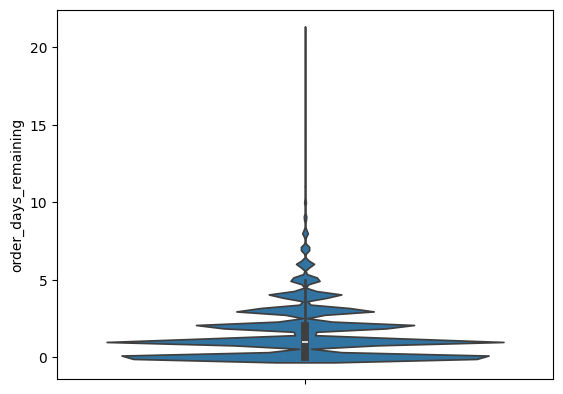

In [101]:
import seaborn as sns 

sns.violinplot(df_user_days['order_days_remaining'].sample(100_000))

<Axes: xlabel='order_days_remaining', ylabel='Count'>

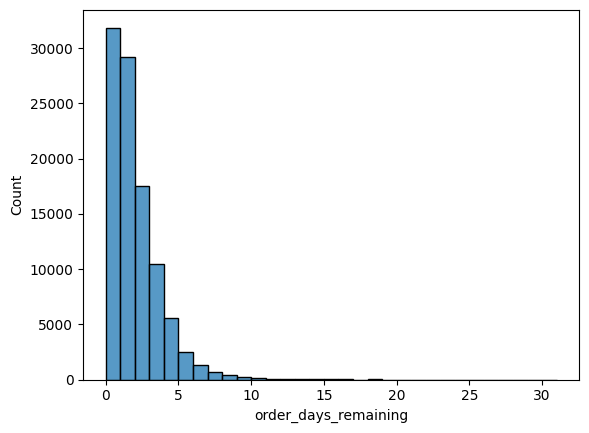

In [102]:
sns.histplot(df_user_days['order_days_remaining'].sample(100_000), bins=range(0, 32))

In [103]:
import matplotlib.pyplot as plt

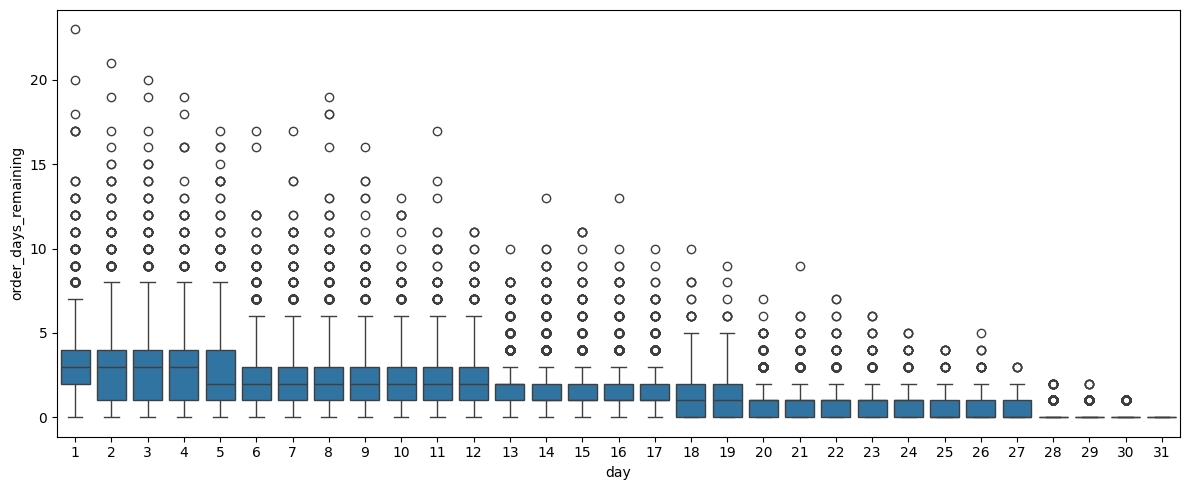

In [104]:
df_user_days['day'] = pd.to_datetime(df_user_days['order_day']).dt.day
plt.figure(figsize=(12,5))
sns.boxplot(x='day', y='order_days_remaining', data=df_user_days.sample(100_000))
plt.tight_layout()

- orders by weekday, month, month_day

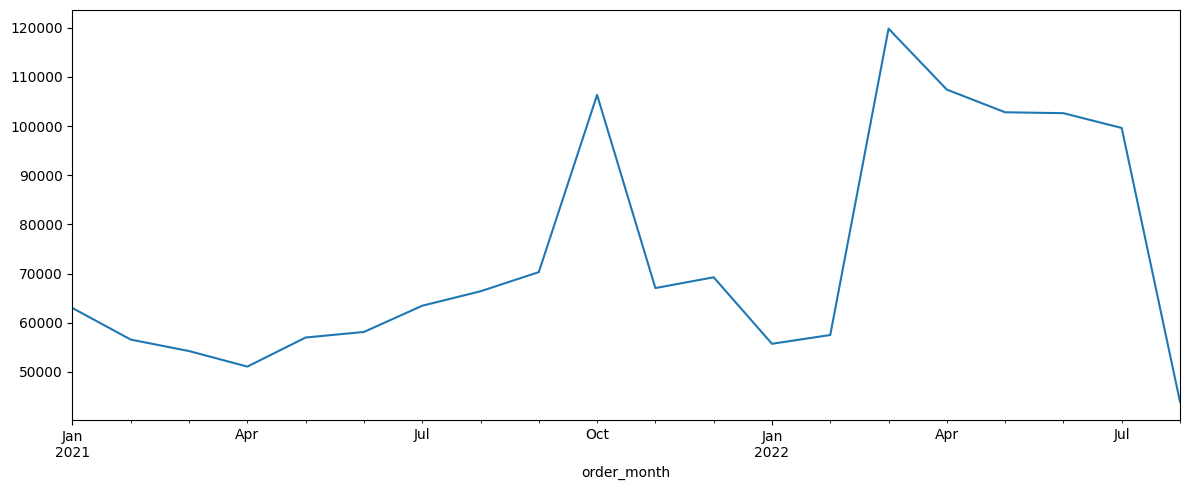

In [105]:
plt.figure(figsize=(12,5))
df_user_days.groupby('order_month')['has_order'].sum().plot()
plt.tight_layout()

<Axes: xlabel='day', ylabel='has_order'>

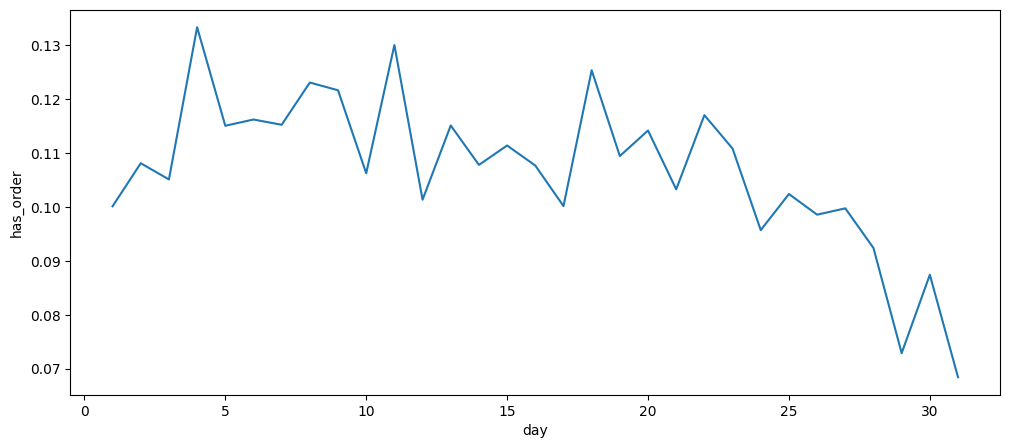

In [106]:
plt.figure(figsize=(12,5))
sns.lineplot(
    data=df_user_days.groupby(df_user_days['day'])['has_order'].mean()
)

In [107]:
### fewer orders on weekends

<Axes: xlabel='weekday', ylabel='has_order'>

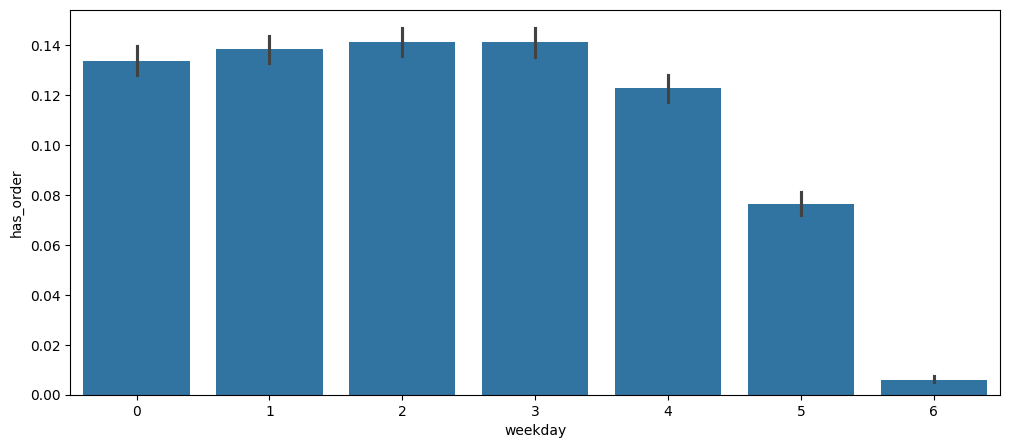

In [108]:
df_user_days['weekday'] = pd.to_datetime(df_user_days['order_day']).dt.dayofweek
plt.figure(figsize=(12,5))
sns.barplot(x='weekday', y='has_order', data=df_user_days.sample(100_000))

- order amount behavior and distribution

<Axes: ylabel='total_order_amount'>

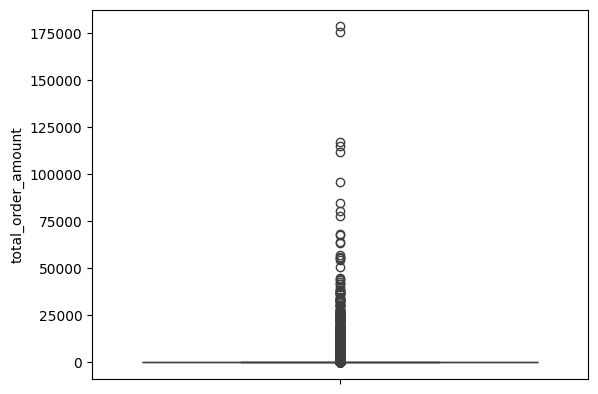

In [109]:
sns.boxplot(df_user_days['total_order_amount'].sample(100_000))

In [110]:
df_user_days[df_user_days['total_order_amount'] != 0]['total_order_amount'].describe() 

count    1.451500e+06
mean     1.697296e+03
std      7.639076e+03
min      4.000000e+00
25%      2.468800e+02
50%      5.591200e+02
75%      1.315633e+03
max      1.765955e+06
Name: total_order_amount, dtype: float64

In [111]:
### 75% of orders have a total value less than 1300

<Axes: ylabel='total_order_amount'>

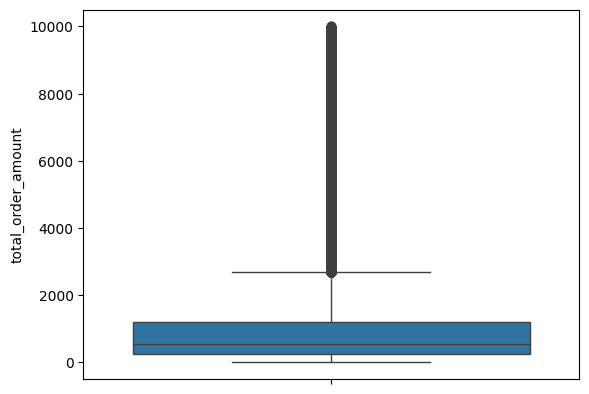

In [112]:
sns.boxplot(df_user_days[(df_user_days['total_order_amount'] <  10000) & (df_user_days['total_order_amount'] > 0)]['total_order_amount'].sample(100_000), )

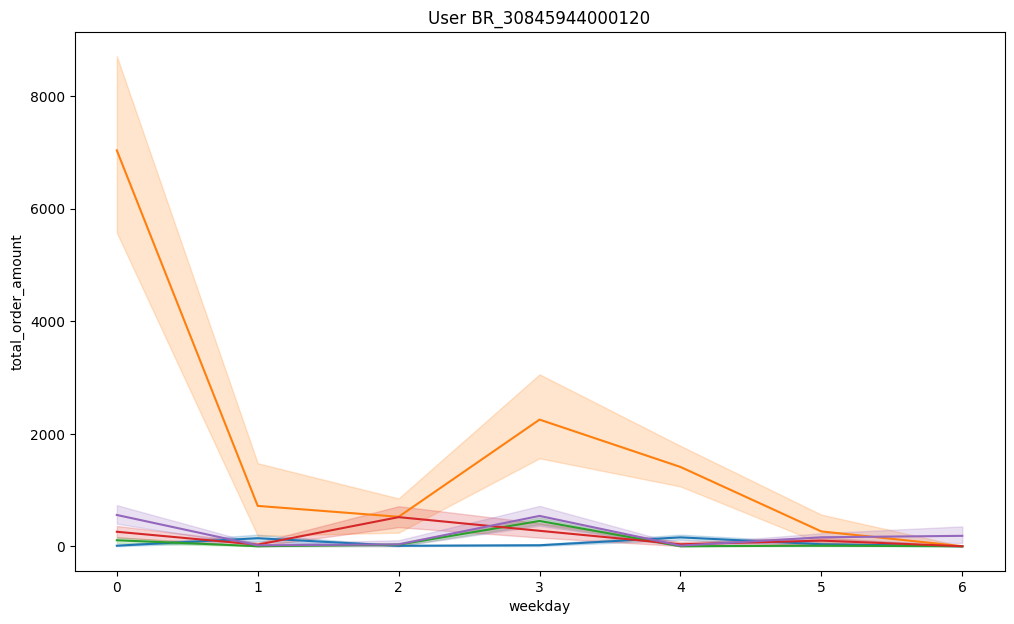

In [113]:
sample_users = df_user_days['account_id'].value_counts().head(5).index ### looking for some users behavior just to explore
plt.figure(figsize=(12,7))
for uid in sample_users:
    subset = df_user_days[df_user_days['account_id'] == uid]
    sns.lineplot(x='weekday', y='total_order_amount', data=subset)
    plt.title(f'User {uid}')
plt.show()

In [114]:
df_user_days['is_weekend'] = df_user_days['weekday'].isin([5, 6]).astype(int)

In [115]:
df_user_days.columns

Index(['account_id', 'order_month', 'current_day', 'order_day', 'has_order',
       'order_days_remaining', 'total_order_amount', 'day', 'weekday',
       'is_weekend'],
      dtype='object')

In [116]:
df_user_days = df_user_days.drop(columns =['current_day'])

In [117]:
df_user_days.to_parquet('./df_historical_expanded.parquet')

## feature engineering part 2

- Here I chose to use pyspark due to the volume that the data had after an expansion

In [1]:

import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("test")
    .master("local[*]") 
    .config("spark.sql.shuffle.partitions", "8")  
    .config("spark.driver.memory", "8g")          
    .config("spark.executor.memory", "8g")        
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")  
    .getOrCreate()
)

25/07/02 02:32:09 WARN Utils: Your hostname, amaury-Nitro-AN515-52 resolves to a loopback address: 127.0.1.1; using 192.168.3.108 instead (on interface wlp0s20f3)
25/07/02 02:32:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/02 02:32:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_historical_expanded = spark.read.parquet('./df_historical_expanded.parquet')

In [3]:
df_historical_expanded.printSchema()

root
 |-- account_id: string (nullable = true)
 |-- order_month: long (nullable = true)
 |-- order_day: date (nullable = true)
 |-- has_order: double (nullable = true)
 |-- order_days_remaining: double (nullable = true)
 |-- total_order_amount: double (nullable = true)
 |-- day: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- is_weekend: long (nullable = true)



In [4]:
df_historical_expanded.show()

+-----------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+
|       account_id|order_month| order_day|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|
+-----------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+
|BR_09607801000194|        619|2021-08-01|      0.0|                 5.0|               0.0|  1|      6|         1|
|BR_09607801000194|        619|2021-08-02|      0.0|                 5.0|               0.0|  2|      0|         0|
|BR_09607801000194|        619|2021-08-03|      0.0|                 5.0|               0.0|  3|      1|         0|
|BR_09607801000194|        619|2021-08-04|      0.0|                 5.0|               0.0|  4|      2|         0|
|BR_09607801000194|        619|2021-08-05|      1.0|                 4.0|         104673.14|  5|      3|         0|
|BR_09607801000194|        619|2021-08-06|      0.0|                 4.0

In [5]:
df_historical_expanded.select('order_month').distinct().show(5)

+-----------+
|order_month|
+-----------+
|        624|
|        616|
|        620|
|        630|
|        617|
+-----------+
only showing top 5 rows



In [6]:
df_historical_expanded = df_historical_expanded.withColumn(
    "order_month",
    f.date_format("order_day", "yyyy-MM")
)

df_historical_expanded.select('order_month', 'order_day').distinct().show(5)

+-----------+----------+
|order_month| order_day|
+-----------+----------+
|    2021-08|2021-08-02|
|    2021-08|2021-08-05|
|    2021-08|2021-08-23|
|    2022-06|2022-06-03|
|    2022-06|2022-06-05|
+-----------+----------+
only showing top 5 rows



In [7]:
from pyspark.sql import Window
from collections import Counter

In [8]:
### create a sorted window for day and user
window_spec_inclusive = (
    Window
    .partitionBy("account_id")
    .orderBy("order_day")
    .rowsBetween(Window.unboundedPreceding, 0)
)

window_spec_exclusive = (
    Window
    .partitionBy("account_id")
    .orderBy("order_day")
    .rowsBetween(Window.unboundedPreceding, -1)
)

In [9]:
df_orders = df_historical_expanded.filter("has_order == 1")

def compute_mode_udf(values):
    if not values:
        return None
    return Counter(values).most_common(1)[0][0]

mode_udf = f.udf(compute_mode_udf, t.IntegerType())

df_orders = df_orders.withColumn(
    "favorite_weekday",
    mode_udf(f.collect_list("weekday").over(window_spec_inclusive))
)

In [10]:
df_orders.show()

+--------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+----------------+
|    account_id|order_month| order_day|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|
+--------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+----------------+
|BR_00002536340|    2021-10|2021-10-02|      1.0|                 3.0|              26.0|  2|      5|         1|               5|
|BR_00002536340|    2021-10|2021-10-04|      1.0|                 2.0|            4006.0|  4|      0|         0|               5|
|BR_00002536340|    2021-10|2021-10-09|      1.0|                 1.0|            4006.0|  9|      5|         1|               5|
|BR_00002536340|    2021-10|2021-10-18|      1.0|                 0.0|            4006.0| 18|      0|         0|               5|
|BR_00002536340|    2022-02|2022-02-28|      1.0|                 0.0|            1236.0| 

In [11]:
df_historical_expanded = df_historical_expanded.join(
    df_orders.select("account_id", "order_day", "favorite_weekday"),
    on=["account_id", "order_day"],
    how="left"
)

In [12]:
df_historical_expanded.filter("account_id == 'BR_00000343803'").orderBy('order_day').show(20)

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+
|BR_00000343803|2021-01-01|    2021-01|      0.0|                 4.0|               0.0|  1|      4|         0|            NULL|
|BR_00000343803|2021-01-02|    2021-01|      0.0|                 4.0|               0.0|  2|      5|         1|            NULL|
|BR_00000343803|2021-01-03|    2021-01|      0.0|                 4.0|               0.0|  3|      6|         1|            NULL|
|BR_00000343803|2021-01-04|    2021-01|      0.0|                 4.0|               0.0|  4|      0|         0|            NULL|
|BR_00000343803|2021-01-05|    2021-01|      0.0|                 4.0|               0.0| 

In [13]:
# forward fill with notnull last 
df_historical_expanded = df_historical_expanded.withColumn(
    "favorite_weekday",
    f.last("favorite_weekday", ignorenulls=True).over(window_spec_inclusive)
)

In [14]:
df_historical_expanded.filter("account_id == 'BR_00101339000184'").orderBy('order_day').show(25)

+-----------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+
|       account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|
+-----------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+
|BR_00101339000184|2021-01-01|    2021-01|      0.0|                 6.0|               0.0|  1|      4|         0|            NULL|
|BR_00101339000184|2021-01-02|    2021-01|      0.0|                 6.0|               0.0|  2|      5|         1|            NULL|
|BR_00101339000184|2021-01-03|    2021-01|      0.0|                 6.0|               0.0|  3|      6|         1|            NULL|
|BR_00101339000184|2021-01-04|    2021-01|      0.0|                 6.0|               0.0|  4|      0|         0|            NULL|
|BR_00101339000184|2021-01-05|    2021-01|      0.0|                 

In [15]:
df_orders = (
    df_historical_expanded
    .filter(f.col("has_order") == 1)
    .withColumn("avg_order_value", f.avg("total_order_amount").over(window_spec_inclusive))
    .withColumn("min_order_value", f.min("total_order_amount").over(window_spec_inclusive))
    .withColumn("max_order_value", f.max("total_order_amount").over(window_spec_inclusive))
    .withColumn("std_order_value", f.stddev("total_order_amount").over(window_spec_inclusive))
    .withColumn("total_order_value", f.sum("total_order_amount").over(window_spec_inclusive))
)

In [16]:
df_orders.show()

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+---------------+---------------+------------------+------------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|   avg_order_value|min_order_value|max_order_value|   std_order_value| total_order_value|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+---------------+---------------+------------------+------------------+
|BR_00002536340|2021-10-02|    2021-10|      1.0|                 3.0|              26.0|  2|      5|         1|               5|              26.0|           26.0|           26.0|              NULL|              26.0|
|BR_00002536340|2021-10-04|    2021-10|      1.0|                 2.0|            4006.0|  4|      0|         0|            

In [17]:
df_historical_expanded = df_historical_expanded.join(
    df_orders.select("account_id", "order_day",
                          "avg_order_value",
                          "total_order_value",
                          "std_order_value",
                          "min_order_value",
                          "max_order_value"),
    on=["account_id", "order_day"],
    how="left"
)

In [18]:
for colname in ["avg_order_value", "total_order_value", "std_order_value","min_order_value","max_order_value"]:
    df_historical_expanded = df_historical_expanded.withColumn(
        colname,
        f.last(colname, ignorenulls=True).over(window_spec_inclusive )
    )

In [19]:
df_historical_expanded.filter("account_id == 'BR_00000343803'").orderBy('order_day').show()

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+---------------+-----------------+-----------------+---------------+---------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|avg_order_value|total_order_value|  std_order_value|min_order_value|max_order_value|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+---------------+-----------------+-----------------+---------------+---------------+
|BR_00000343803|2021-01-01|    2021-01|      0.0|                 4.0|               0.0|  1|      4|         0|            NULL|           NULL|             NULL|             NULL|           NULL|           NULL|
|BR_00000343803|2021-01-02|    2021-01|      0.0|                 4.0|               0.0|  2|      5|         1|            NULL|           NULL

In [21]:
window_month = (
    Window
    .partitionBy("account_id", "order_month")
    .orderBy("order_day")
    .rowsBetween(Window.unboundedPreceding, 0)
)

df_historical_expanded = df_historical_expanded.withColumn(
    "total_orders_current_month",
    f.sum("has_order").over(window_month)
)

In [22]:
df_historical_expanded = df_historical_expanded.withColumn(
    "total_orders_so_far",
    f.sum("has_order").over(window_spec_inclusive)
)

In [23]:
df_historical_expanded.filter("account_id == 'BR_00000343803'").orderBy('order_day').show(32)

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+-----------------+------------------+---------------+---------------+--------------------------+-------------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|   avg_order_value|total_order_value|   std_order_value|min_order_value|max_order_value|total_orders_current_month|total_orders_so_far|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+-----------------+------------------+---------------+---------------+--------------------------+-------------------+
|BR_00000343803|2021-01-01|    2021-01|      0.0|                 4.0|               0.0|  1|      4|         0|            NULL|              NULL|             NULL|              NULL|           NULL|    

In [24]:
df_monthly_aux = (
    df_historical_expanded
    .filter(f.col("has_order") == 1)
    .groupBy("account_id", "order_month")
    .agg(f.countDistinct("order_day").alias("order_days_in_month"))
)

window_months_so_far = (
    Window
    .partitionBy("account_id")
    .orderBy("order_month")
    .rowsBetween(Window.unboundedPreceding, -1)  
)

df_monthly_aux = (
    df_monthly_aux
    .withColumn("avg_orders_per_month", f.avg("order_days_in_month").over(window_months_so_far))
    .withColumn("max_orders_per_month", f.max("order_days_in_month").over(window_months_so_far))
    .withColumn("std_orders_per_month", f.stddev("order_days_in_month").over(window_months_so_far))
)

df_monthly_aux.show()

+-----------------+-----------+-------------------+--------------------+--------------------+--------------------+
|       account_id|order_month|order_days_in_month|avg_orders_per_month|max_orders_per_month|std_orders_per_month|
+-----------------+-----------+-------------------+--------------------+--------------------+--------------------+
|   BR_00002536340|    2021-10|                  4|                NULL|                NULL|                NULL|
|   BR_00002536340|    2022-02|                  1|                 4.0|                   4|                NULL|
|   BR_00002536340|    2022-03|                  4|                 2.5|                   4|  2.1213203435596424|
|   BR_00002536340|    2022-04|                  3|                 3.0|                   4|  1.7320508075688772|
|   BR_00002536340|    2022-05|                  4|                 3.0|                   4|  1.4142135623730951|
|   BR_00002536340|    2022-06|                  4|                 3.2|        

In [25]:
df_historical_expanded = df_historical_expanded.join(
    df_monthly_aux.select(
        "account_id", "order_month",
        "avg_orders_per_month",
        "max_orders_per_month",
        "std_orders_per_month"
    ),
    on=["account_id", "order_month"],
    how="left"
)

In [26]:
df_historical_expanded.filter("account_id == 'BR_00000343803'").filter('has_order == 1').orderBy('order_day').show(32)

+--------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+--------------------------+-------------------+--------------------+--------------------+--------------------+
|    account_id|order_month| order_day|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|   avg_order_value| total_order_value|   std_order_value|min_order_value|   max_order_value|total_orders_current_month|total_orders_so_far|avg_orders_per_month|max_orders_per_month|std_orders_per_month|
+--------------+-----------+----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+--------------------------+-------------------+--------------------+--------------------+--------------------+
|BR_

In [27]:
df_orders = df_historical_expanded.filter(f.col("has_order") == 1).select(
    "account_id", "order_day"
)

window_order = (
    Window
    .partitionBy("account_id")
    .orderBy("order_day")
)

# Previous order date lag
df_orders = df_orders.withColumn(
    "prev_order_day",
    f.lag("order_day").over(window_order)
)
df_orders = df_orders.withColumn(
    "days_since_last_order",
    f.datediff("order_day", "prev_order_day")
)

In [28]:
window_until_now = (
    Window
    .partitionBy("account_id")
    .orderBy("order_day")
    .rowsBetween(Window.unboundedPreceding, -1) # until before current request
)

df_orders = df_orders.withColumn(
    "avg_days_between_orders",
    f.avg("days_since_last_order").over(window_until_now)
)

df_orders.show(7)

+--------------+----------+--------------+---------------------+-----------------------+
|    account_id| order_day|prev_order_day|days_since_last_order|avg_days_between_orders|
+--------------+----------+--------------+---------------------+-----------------------+
|BR_00002536340|2021-10-02|          NULL|                 NULL|                   NULL|
|BR_00002536340|2021-10-04|    2021-10-02|                    2|                   NULL|
|BR_00002536340|2021-10-09|    2021-10-04|                    5|                    2.0|
|BR_00002536340|2021-10-18|    2021-10-09|                    9|                    3.5|
|BR_00002536340|2022-02-28|    2021-10-18|                  133|      5.333333333333333|
|BR_00002536340|2022-03-07|    2022-02-28|                    7|                  37.25|
|BR_00002536340|2022-03-15|    2022-03-07|                    8|                   31.2|
+--------------+----------+--------------+---------------------+-----------------------+
only showing top 7 ro

In [29]:
df_historical_expanded = df_historical_expanded.join(
    df_orders.select(
        "account_id", "order_day", 
        "days_since_last_order", 
        "avg_days_between_orders"
    ),
    on=["account_id", "order_day"],
    how="left"
)

In [30]:
df_historical_expanded.filter("account_id == 'BR_00000343803'").filter('has_order == 1').orderBy('order_day').show(10)

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+--------------------------+-------------------+--------------------+--------------------+--------------------+---------------------+-----------------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|   avg_order_value| total_order_value|   std_order_value|min_order_value|   max_order_value|total_orders_current_month|total_orders_so_far|avg_orders_per_month|max_orders_per_month|std_orders_per_month|days_since_last_order|avg_days_between_orders|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+-----------------------

In [31]:
df_historical_expanded.columns

['account_id',
 'order_day',
 'order_month',
 'has_order',
 'order_days_remaining',
 'total_order_amount',
 'day',
 'weekday',
 'is_weekend',
 'favorite_weekday',
 'avg_order_value',
 'total_order_value',
 'std_order_value',
 'min_order_value',
 'max_order_value',
 'total_orders_current_month',
 'total_orders_so_far',
 'avg_orders_per_month',
 'max_orders_per_month',
 'std_orders_per_month',
 'days_since_last_order',
 'avg_days_between_orders']

In [32]:
df_historical_expanded.write.parquet('./df_historical_expanded_final.parquet')

## modeling

In [1]:
from pyspark.sql import Window
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("analise")
    .master("local[*]") 
    .config("spark.sql.shuffle.partitions", "8")  
    .config("spark.driver.memory", "8g")          
    .config("spark.executor.memory", "8g")        
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")  
    .getOrCreate()
)

25/07/02 15:43:17 WARN Utils: Your hostname, amaury-Nitro-AN515-52 resolves to a loopback address: 127.0.1.1; using 192.168.3.108 instead (on interface wlp0s20f3)
25/07/02 15:43:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/02 15:43:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df_hist_final = spark.read.parquet('./df_historical_expanded_final.parquet')

### análise de correlação

In [3]:
df_hist_final.show()

+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+--------------------------+-------------------+--------------------+--------------------+--------------------+---------------------+-----------------------+
|    account_id| order_day|order_month|has_order|order_days_remaining|total_order_amount|day|weekday|is_weekend|favorite_weekday|   avg_order_value| total_order_value|   std_order_value|min_order_value|   max_order_value|total_orders_current_month|total_orders_so_far|avg_orders_per_month|max_orders_per_month|std_orders_per_month|days_since_last_order|avg_days_between_orders|
+--------------+----------+-----------+---------+--------------------+------------------+---+-------+----------+----------------+------------------+------------------+------------------+---------------+------------------+-----------------------

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

It is possible to observe that the variables with the greatest correlation, whether directly or inversely proportional, are variables related to order values, recurrence of purchases and day of purchase.

<Axes: >

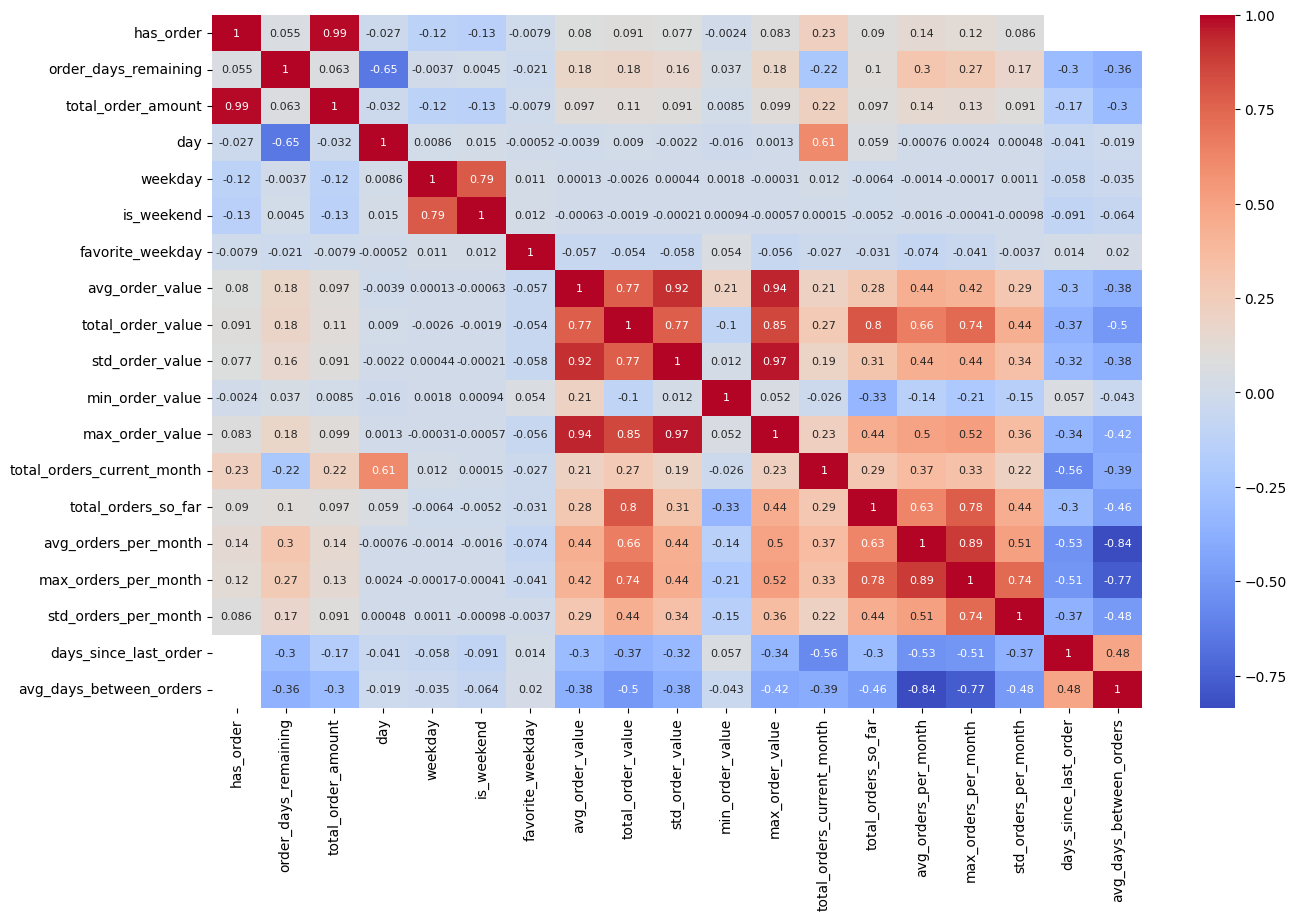

In [15]:
plt.figure(figsize=(15, 9))
sns.heatmap(
    df_hist_final
    .sample(fraction=0.1, seed=4)
    .toPandas()
    .select_dtypes(exclude='object')
    .corr(method='spearman'), 
    cmap="coolwarm", 
    annot=True,  
    annot_kws={"size": 8}
)

-----

I will also test using a sample traning data with no common user with the test data to check generalizability.

### split train, test and predict

In [3]:
df_hist_final.count()

13687565

In [4]:
df_august_order_original = spark.read.parquet('./august_with_missing_order_days.parquet')

In [5]:
df_august_order_original.select('account_id').distinct().count()

32944

In [6]:
df_august_order_original.groupBy("account_id").agg(f.count_distinct('order_date').alias('count_diff_days_order')).filter('count_diff_days_order > 1').show(10)

+-----------------+---------------------+
|       account_id|count_diff_days_order|
+-----------------+---------------------+
|   BR_87953072300|                   11|
|BR_02649357000120|                    8|
|   BR_98792792634|                    2|
|BR_31191298000198|                    5|
|BR_36206379000219|                    8|
|BR_34833341000160|                    2|
|   BR_01261330340|                    3|
|BR_01384407000122|                    2|
|BR_33208745000108|                    9|
|   BR_53924606749|                    2|
+-----------------+---------------------+
only showing top 10 rows



there is some multiple order_date for the users

In [7]:
df_august_order_original.filter("account_id == 'BR_53924606749'").show()

+--------------+----------+------------------+
|    account_id|order_date|transaction_amount|
+--------------+----------+------------------+
|BR_53924606749|2022-08-06|               0.0|
|BR_53924606749|2022-08-06|               0.0|
|BR_53924606749|2022-08-06|              42.9|
|BR_53924606749|2022-08-06|             23.17|
|BR_53924606749|2022-08-06|            137.46|
|BR_53924606749|2022-08-06|             48.68|
|BR_53924606749|2022-08-06|            136.16|
|BR_53924606749|2022-08-06|            172.72|
|BR_53924606749|2022-08-06|               0.0|
|BR_53924606749|2022-08-06|             86.56|
|BR_53924606749|2022-08-12|             77.91|
|BR_53924606749|2022-08-12|              42.9|
|BR_53924606749|2022-08-12|             42.92|
|BR_53924606749|2022-08-12|            137.46|
|BR_53924606749|2022-08-12|            129.84|
|BR_53924606749|2022-08-12|             215.9|
+--------------+----------+------------------+



- In the final prediction dataset, I select the latest available day per user (i.e., the most recent row) and simulate the prediction from that point forward. 
- All features are constructed based only on the historical data up to and including that day, avoiding any data leakage from future orders. 
- For users with no available order history in August (NaT), I generate predictions as of August 1st, assuming no prior activity.

In [8]:
df_august_order_original = df_august_order_original.fillna({'order_date': '2022-08-01'})

In [9]:
window_spec = Window.partitionBy('account_id').orderBy(f.col('order_date').desc())

df_august_order_original= df_august_order_original.withColumn('rank', f.row_number().over(window_spec))

df_august_order_last_record = df_august_order_original.filter(f.col('rank') == 1).drop('rank').select('account_id', 'order_date')
df_august_order_last_record.count()

32944

In [10]:
df_august_order_last_record.filter("account_id == 'BR_53924606749'").show()

+--------------+----------+
|    account_id|order_date|
+--------------+----------+
|BR_53924606749|2022-08-12|
+--------------+----------+



In [11]:
df_predict = (  
    df_hist_final
    .join(
        df_august_order_last_record.withColumnRenamed('order_date', 'order_day'),
        on=['account_id', 'order_day'],
        how='inner'
    )
)

In [12]:
df_predict.count()

32944

In [89]:
df_predict_pd = df_predict.toPandas()

In [13]:
df_validation = df_hist_final.filter(f.col('order_month') == '2022-07').sample(fraction=0.3, seed=4) ## validation in july
df_validation_pd = df_validation.toPandas()

In [14]:
df_validation_pd.shape

(293937, 22)

In [15]:
df_test = df_hist_final.filter(f.col('order_month') == '2022-06').sample(fraction=0.3, seed=4) ## testing in jun
df_test_pd = df_test.toPandas()

In [16]:
df_test_pd.shape

(283828, 22)

In [17]:
df_train_users_separation = (
    df_hist_final
    .filter(f.col('order_month') < '2022-06')
    .join(
        df_test
        .select('account_id')
        .distinct(),
        on = 'account_id',
        how='left_anti'   #anti join to remove common users
    )
    .join(
        df_validation
        .select('account_id')
        .distinct(),
        on = 'account_id',
        how='left_anti'   #anti join to remove common users
    )
    
)
df_train_users_separation.count()

1851457

In [18]:
df_train_users_separation = df_train_users_separation.sample(fraction=0.3, seed=4)
df_train_users_separation_pd = df_train_users_separation.toPandas()

In [19]:
df_train_users_separation_pd.shape

(555053, 22)

In [35]:
df_train = df_hist_final.filter(f.col('order_month') < '2022-06').sample(fraction=0.08, seed=4)
df_train_pd = df_train.toPandas()

In [36]:
df_train_pd.shape

(859461, 22)

In [20]:
df_hist_final.filter(f.col('order_month') < '2022-08').count()

12666301

In [27]:
df_train_final = df_hist_final.filter(f.col('order_month') < '2022-08').sample(fraction=0.07, seed=4)
df_train_final_pd = df_train_final.toPandas()

In [25]:
df_train_final_pd.shape

(886288, 22)

----

### model no users separation 

In [37]:
df_train_pd.columns

Index(['account_id', 'order_day', 'order_month', 'has_order',
       'order_days_remaining', 'total_order_amount', 'day', 'weekday',
       'is_weekend', 'favorite_weekday', 'avg_order_value',
       'total_order_value', 'std_order_value', 'min_order_value',
       'max_order_value', 'total_orders_current_month', 'total_orders_so_far',
       'avg_orders_per_month', 'max_orders_per_month', 'std_orders_per_month',
       'days_since_last_order', 'avg_days_between_orders'],
      dtype='object')

In [38]:
ignore_cols = ['account_id', 'order_day', 'order_month']

In [39]:
X_train = df_train_pd.drop(columns=['has_order', 'order_days_remaining']) #drop target and target leak
X_test = df_test_pd.drop(columns=['has_order', 'order_days_remaining'])

In [40]:
y_train = df_train_pd['order_days_remaining'] 
y_test = df_test_pd['order_days_remaining']

I chose to use LightGBM Regressor because it is well-suited for tabular data with mixed feature types, missing values, and potential non-linear relationships. It provides fast training and strong predictive performance out of the box, making it ideal for iterative experimentation and feature-rich problems like this one. Additionally, it supports native handling of missing values and allows for interpretable results using SHAP values or feature importance.

In [41]:
from lightgbm import LGBMRegressor

model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=4) 

In [42]:
model.fit(X_train.drop(columns=ignore_cols), y_train,)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2756
[LightGBM] [Info] Number of data points in the train set: 859461, number of used features: 17
[LightGBM] [Info] Start training from score 1.628544


LGBMRegressor(random_state=4)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

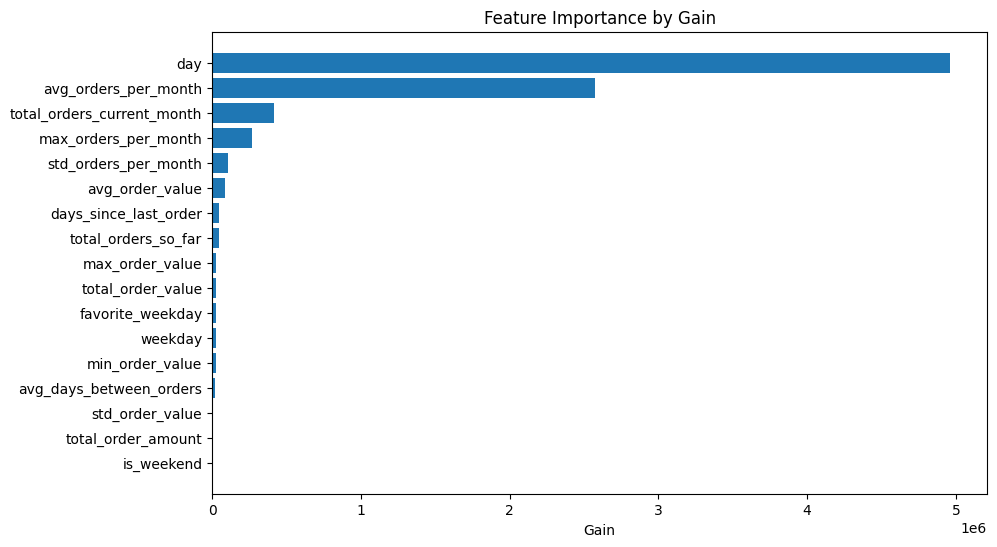

In [46]:
model.booster_.feature_importance(importance_type='gain')
feature_names = model.booster_.feature_name()

# Criar DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_gain': model.booster_.feature_importance(importance_type='gain')
}).sort_values(by='importance_gain', ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance_gain'])
plt.gca().invert_yaxis()
plt.title('Feature Importance by Gain')
plt.xlabel('Gain')
plt.show()

- analise shap

In [47]:
X_train_sample = X_train.drop(columns=ignore_cols).sample(n=10_000, random_state=42)
X_test_sample = X_test.drop(columns=ignore_cols).sample(n=10_000, random_state=42)

/home/amaury/miniconda3/envs/mestrado/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 97%|=================== | 9727/10000 [00:35<00:00]       

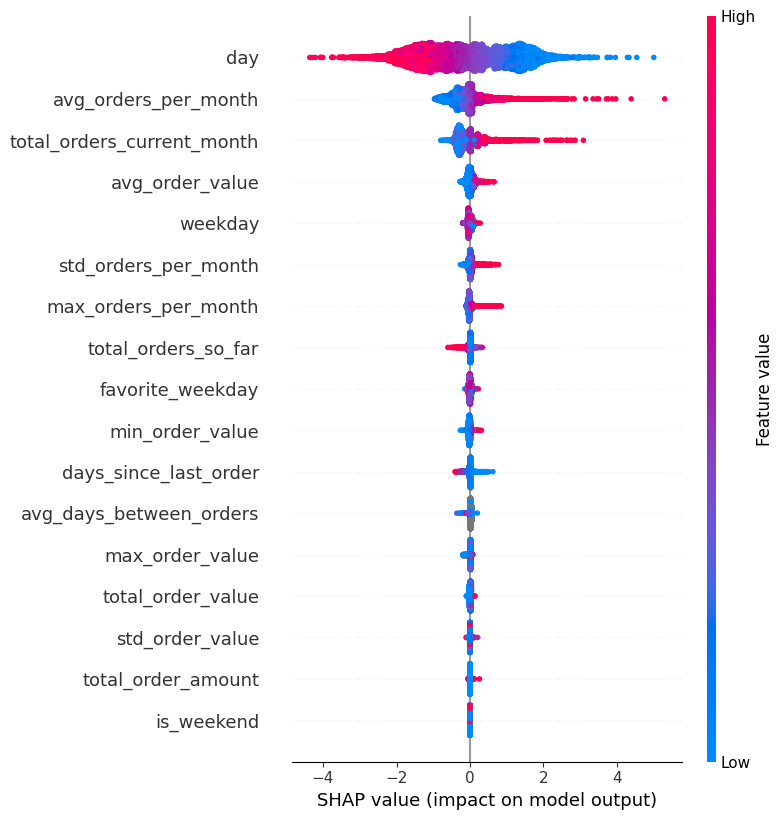

In [48]:
import shap

shap.initjs()
explainer = shap.Explainer(model, X_train_sample )

shap_values = explainer(X_test_sample)

shap.summary_plot(shap_values, X_test_sample )

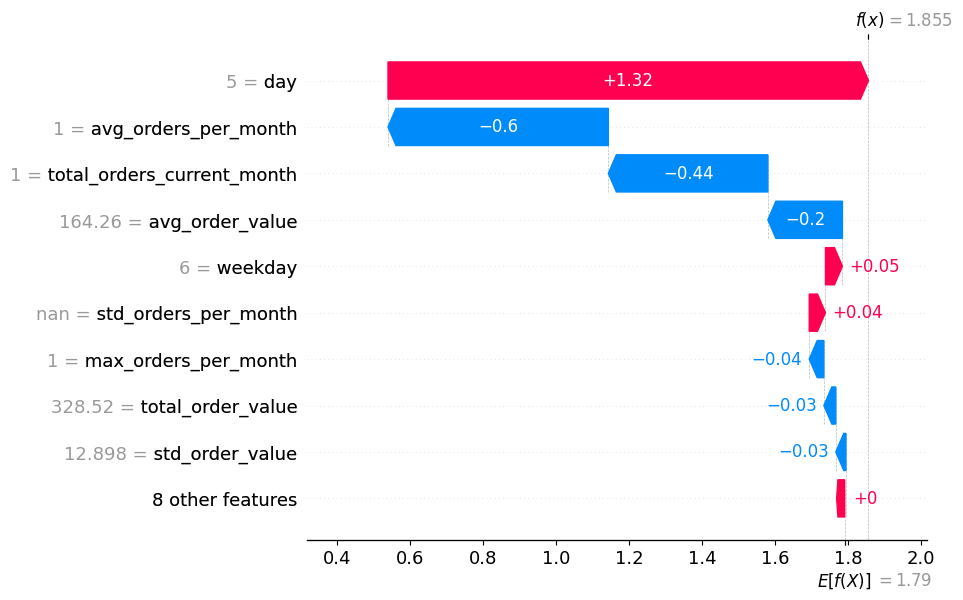

In [49]:
shap.plots.waterfall(shap_values[0])  

#### validation

In [50]:
y_pred = model.predict(X_test.drop(columns=ignore_cols))

I will focus mainly on MAE, I am using RMSE only as an additional

In [51]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, y_pred) 
rmse = root_mean_squared_error(y_test, y_pred) 


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.71
RMSE: 1.00


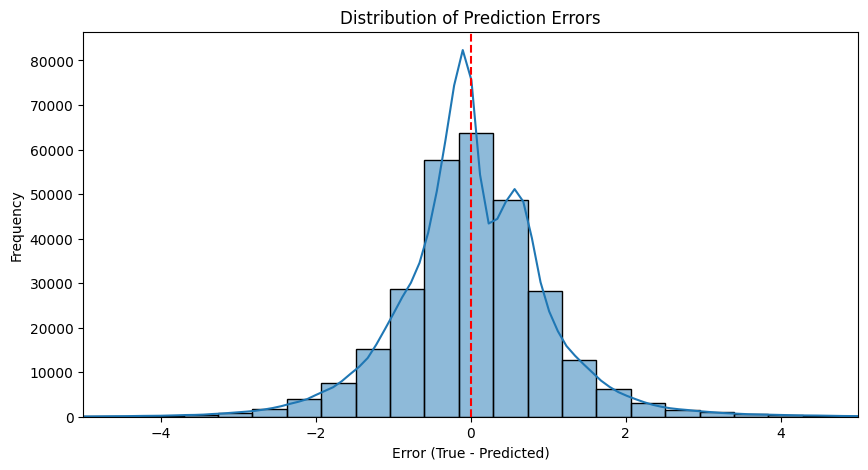

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = y_test - y_pred

plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (True - Predicted)")
plt.xlim(-5,5)
plt.ylabel("Frequency")
plt.show()

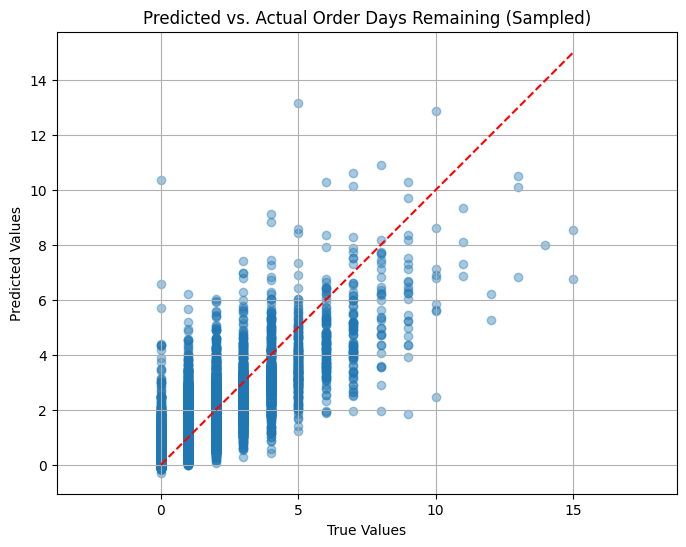

In [53]:
df_plot = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).sample(n=10000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(df_plot['y_true'], df_plot['y_pred'], alpha=0.4)
plt.plot([df_plot['y_true'].min(), df_plot['y_true'].max()], 
         [df_plot['y_true'].min(), df_plot['y_true'].max()], 
         'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Order Days Remaining (Sampled)")
plt.axis('equal')
plt.grid()
plt.show()


In [56]:
X_validation = df_train_users_separation_pd.drop(columns=['has_order', 'order_days_remaining']) 
y_validation = df_train_users_separation_pd['order_days_remaining'] 

In [58]:
y_pred_2 = model.predict(X_validation.drop(columns=ignore_cols))

In [59]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_validation, y_pred_2) 
rmse = root_mean_squared_error(y_validation, y_pred_2) 


print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.70
RMSE: 0.99


### model with user separation

In [62]:
del X_train

In [64]:
X_train_separation = df_train_users_separation_pd.drop(columns=['has_order', 'order_days_remaining']) 

In [65]:
y_train_separation = df_train_users_separation_pd['order_days_remaining']

I chose to use LightGBM Regressor because it is well-suited for tabular data with mixed feature types, missing values, and potential non-linear relationships. It provides fast training and strong predictive performance out of the box, making it ideal for iterative experimentation and feature-rich problems like this one. Additionally, it supports native handling of missing values and allows for interpretable results using SHAP values or feature importance.

In [66]:
from lightgbm import LGBMRegressor

model_separation = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=4) 

In [67]:
model_separation.fit(X_train_separation.drop(columns=ignore_cols), y_train_separation,)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 555053, number of used features: 17
[LightGBM] [Info] Start training from score 1.190742


LGBMRegressor(random_state=4)

In [68]:
import pandas as pd

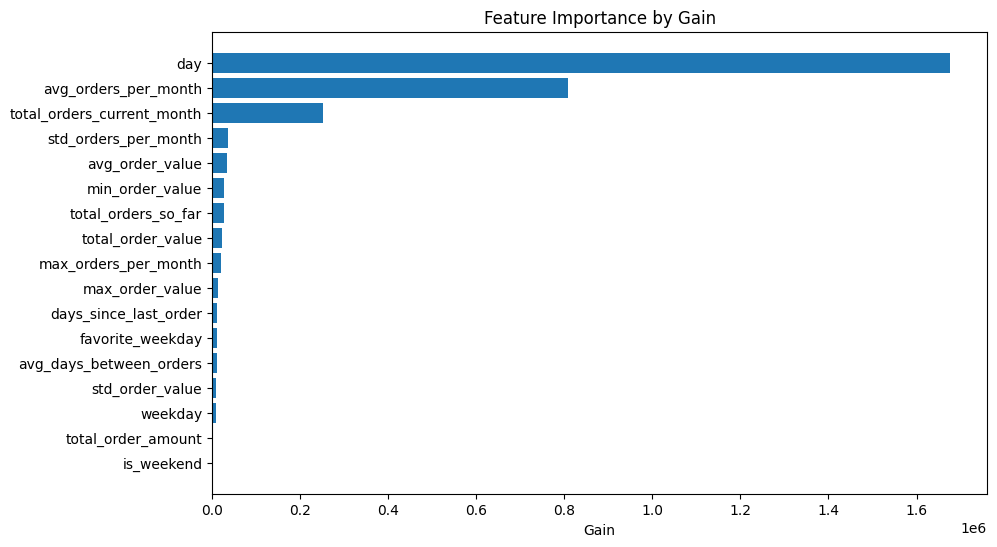

In [69]:
model_separation.booster_.feature_importance(importance_type='gain')
feature_names = model_separation.booster_.feature_name()

# Criar DataFrame
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance_gain': model_separation.booster_.feature_importance(importance_type='gain')
}).sort_values(by='importance_gain', ascending=False)

# Plotar
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance_gain'])
plt.gca().invert_yaxis()
plt.title('Feature Importance by Gain')
plt.xlabel('Gain')
plt.show()

### validation

In [70]:
y_pred = model_separation.predict(X_test.drop(columns=ignore_cols))

Although the error increased a little bit, it was possible to notice that it was able to generalize to users who were not in the training base

In [71]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

mae = mean_absolute_error(y_test, y_pred) 
rmse = root_mean_squared_error(y_test, y_pred) 

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.75
RMSE: 1.07


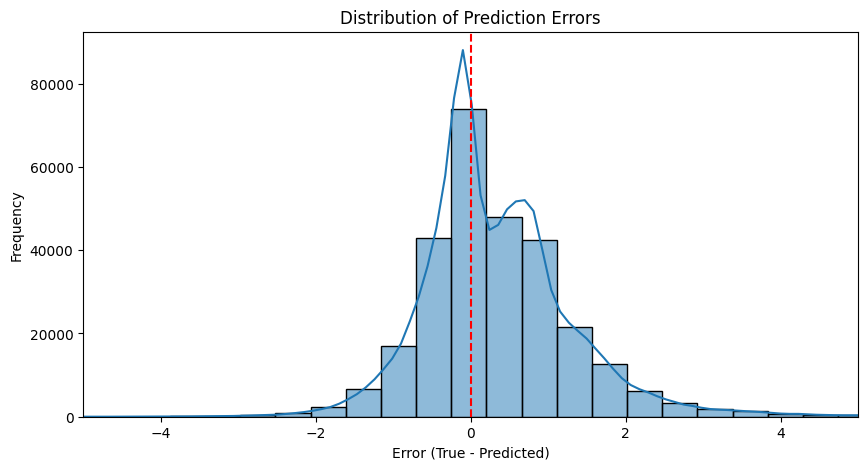

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = y_test - y_pred

plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (True - Predicted)")
plt.xlim(-5,5)
plt.ylabel("Frequency")
plt.show()

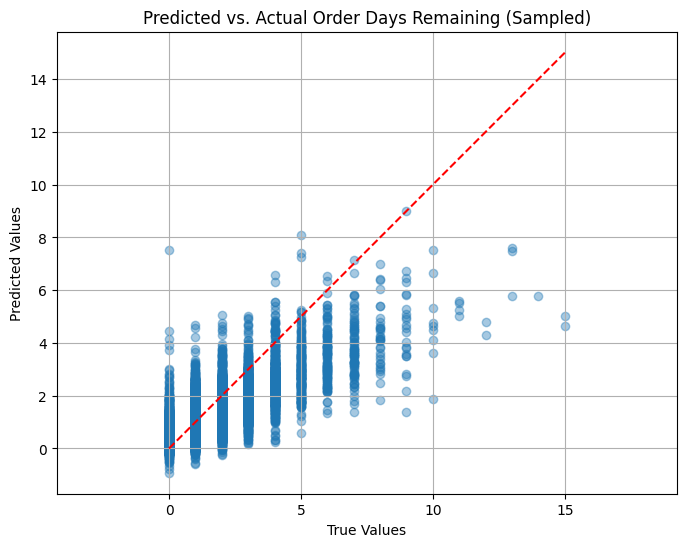

In [73]:
df_plot = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).sample(n=10000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(df_plot['y_true'], df_plot['y_pred'], alpha=0.4)
plt.plot([df_plot['y_true'].min(), df_plot['y_true'].max()], 
         [df_plot['y_true'].min(), df_plot['y_true'].max()], 
         'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Order Days Remaining (Sampled)")
plt.axis('equal')
plt.grid()
plt.show()


#### tuning

In [80]:
from lightgbm import early_stopping

def objective(trial, X_train, y_train, X_test, y_test, ):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True)
    }

    model = LGBMRegressor(**params, n_estimators=500, random_state=42)
    model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        callbacks=[early_stopping(50)]
    )

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [ ]:
import optuna

study = optuna.create_study(direction='minimize')
study.optimize(
    lambda trial: objective(
            trial, 
            X_train_separation.drop(columns=ignore_cols), 
            y_train_separation, 
            X_test.drop(columns=ignore_cols), 
            y_test
        ), 
    n_trials=50
)

print("Best MAE:", study.best_value)
print("Best hyperparameters:", study.best_params)

[I 2025-07-02 13:36:16,020] A new study created in memory with name: no-name-01c2159e-066a-4ed3-a84e-df80eb869190


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's l1: 0.661662


[I 2025-07-02 13:37:28,675] Trial 0 finished with value: 0.6616620120127337 and parameters: {'learning_rate': 0.04483665035164695, 'num_leaves': 243, 'max_depth': 12, 'min_child_samples': 36, 'subsample': 0.772115672372883, 'colsample_bytree': 0.519795009529262, 'reg_alpha': 0.01270591460415992, 'reg_lambda': 0.07655715330463922}. Best is trial 0 with value: 0.6616620120127337.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.72428


[I 2025-07-02 13:37:56,545] Trial 1 finished with value: 0.7242802737761721 and parameters: {'learning_rate': 0.02340603606559019, 'num_leaves': 139, 'max_depth': 3, 'min_child_samples': 72, 'subsample': 0.7790096512436089, 'colsample_bytree': 0.7517368711121148, 'reg_alpha': 3.2225107145291605e-05, 'reg_lambda': 2.812593844430422e-08}. Best is trial 0 with value: 0.6616620120127337.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.655339


[I 2025-07-02 13:39:01,886] Trial 2 finished with value: 0.6553392024600045 and parameters: {'learning_rate': 0.04627828410690463, 'num_leaves': 269, 'max_depth': 16, 'min_child_samples': 90, 'subsample': 0.8482934613492569, 'colsample_bytree': 0.8149730887712846, 'reg_alpha': 9.158728928095528e-08, 'reg_lambda': 0.0014858135917018677}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.694659


[I 2025-07-02 13:39:32,400] Trial 3 finished with value: 0.6946586514846277 and parameters: {'learning_rate': 0.08316300513155084, 'num_leaves': 121, 'max_depth': 4, 'min_child_samples': 74, 'subsample': 0.6375176310245056, 'colsample_bytree': 0.5516170806814132, 'reg_alpha': 5.7659813675695904e-05, 'reg_lambda': 2.9898821125442763}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.669904


[I 2025-07-02 13:40:07,157] Trial 4 finished with value: 0.6699038750931088 and parameters: {'learning_rate': 0.08504853989172262, 'num_leaves': 81, 'max_depth': 19, 'min_child_samples': 43, 'subsample': 0.5467395474878196, 'colsample_bytree': 0.5122067244635926, 'reg_alpha': 3.035846924248683e-07, 'reg_lambda': 0.5450589676894744}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[497]	valid_0's l1: 0.67598


[I 2025-07-02 13:40:43,028] Trial 5 finished with value: 0.6759799426892703 and parameters: {'learning_rate': 0.17602470880982574, 'num_leaves': 47, 'max_depth': 5, 'min_child_samples': 47, 'subsample': 0.900078778485448, 'colsample_bytree': 0.7145246224710209, 'reg_alpha': 7.610568475195415, 'reg_lambda': 0.0032917667454979162}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.691243


[I 2025-07-02 13:41:15,107] Trial 6 finished with value: 0.6912429813191732 and parameters: {'learning_rate': 0.0346658989417442, 'num_leaves': 24, 'max_depth': 10, 'min_child_samples': 74, 'subsample': 0.676266538961434, 'colsample_bytree': 0.9898548595364061, 'reg_alpha': 0.0017623479210389624, 'reg_lambda': 7.916318150442204e-08}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.662618


[I 2025-07-02 13:41:52,431] Trial 7 finished with value: 0.6626182767765024 and parameters: {'learning_rate': 0.12212653780716223, 'num_leaves': 77, 'max_depth': 16, 'min_child_samples': 85, 'subsample': 0.7463911605039794, 'colsample_bytree': 0.7575112991565274, 'reg_alpha': 0.002990919096972413, 'reg_lambda': 7.560164000647641}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.678347


[I 2025-07-02 13:43:10,602] Trial 8 finished with value: 0.6783473530869601 and parameters: {'learning_rate': 0.020280277422410536, 'num_leaves': 146, 'max_depth': 13, 'min_child_samples': 45, 'subsample': 0.8151285253139616, 'colsample_bytree': 0.6208712581546091, 'reg_alpha': 6.649985488620986, 'reg_lambda': 0.15561574031643366}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's l1: 0.687216


[I 2025-07-02 13:43:55,446] Trial 9 finished with value: 0.6872163143686669 and parameters: {'learning_rate': 0.036544093490926396, 'num_leaves': 300, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.8683921163954538, 'colsample_bytree': 0.5199782399024224, 'reg_alpha': 6.050873890135574e-06, 'reg_lambda': 0.05708994559759027}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.679448


[I 2025-07-02 13:45:32,477] Trial 10 finished with value: 0.6794479939853973 and parameters: {'learning_rate': 0.012545648753052245, 'num_leaves': 212, 'max_depth': 20, 'min_child_samples': 99, 'subsample': 0.9986250991034558, 'colsample_bytree': 0.9054748770326608, 'reg_alpha': 1.9965799644146196e-08, 'reg_lambda': 1.2026819411420672e-05}. Best is trial 2 with value: 0.6553392024600045.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.649372


[I 2025-07-02 13:46:14,823] Trial 11 finished with value: 0.649371567945284 and parameters: {'learning_rate': 0.0549196050710048, 'num_leaves': 251, 'max_depth': 12, 'min_child_samples': 8, 'subsample': 0.9319423383791996, 'colsample_bytree': 0.878248882875029, 'reg_alpha': 0.07830675607719945, 'reg_lambda': 0.0002549357113291899}. Best is trial 11 with value: 0.649371567945284.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.647151


[I 2025-07-02 13:47:02,277] Trial 12 finished with value: 0.6471512028506046 and parameters: {'learning_rate': 0.06239958191481805, 'num_leaves': 262, 'max_depth': 15, 'min_child_samples': 6, 'subsample': 0.9715334931888042, 'colsample_bytree': 0.8600179860865451, 'reg_alpha': 0.10471856549885811, 'reg_lambda': 6.750184114021122e-05}. Best is trial 12 with value: 0.6471512028506046.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[499]	valid_0's l1: 0.652799


[I 2025-07-02 13:47:41,486] Trial 13 finished with value: 0.6527993000802029 and parameters: {'learning_rate': 0.06696778291372049, 'num_leaves': 202, 'max_depth': 10, 'min_child_samples': 5, 'subsample': 0.9756014264243842, 'colsample_bytree': 0.8819789245201509, 'reg_alpha': 0.0708756008687889, 'reg_lambda': 1.5097720945789124e-05}. Best is trial 12 with value: 0.6471512028506046.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.653165


[I 2025-07-02 13:48:18,432] Trial 14 finished with value: 0.6531654862590489 and parameters: {'learning_rate': 0.06259968420836745, 'num_leaves': 200, 'max_depth': 15, 'min_child_samples': 5, 'subsample': 0.9229878221942007, 'colsample_bytree': 0.9081794638982359, 'reg_alpha': 0.2239092571336315, 'reg_lambda': 3.517267289590131e-05}. Best is trial 12 with value: 0.6471512028506046.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.634689


[I 2025-07-02 13:49:02,567] Trial 15 finished with value: 0.6346891171026817 and parameters: {'learning_rate': 0.12548048234713136, 'num_leaves': 296, 'max_depth': 9, 'min_child_samples': 23, 'subsample': 0.9414924735795183, 'colsample_bytree': 0.9821109703770157, 'reg_alpha': 0.2121270152209766, 'reg_lambda': 1.4044480444502682e-06}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.638515


[I 2025-07-02 13:49:41,472] Trial 16 finished with value: 0.6385151417292131 and parameters: {'learning_rate': 0.17707403860620236, 'num_leaves': 292, 'max_depth': 8, 'min_child_samples': 22, 'subsample': 0.9568404516529435, 'colsample_bytree': 0.9993920982451628, 'reg_alpha': 0.8742795949458269, 'reg_lambda': 5.933837853866598e-07}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.648925


[I 2025-07-02 13:50:15,559] Trial 17 finished with value: 0.6489249350276214 and parameters: {'learning_rate': 0.19934501505015975, 'num_leaves': 295, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.6913813228286148, 'colsample_bytree': 0.9997942357710068, 'reg_alpha': 1.4215565627527578, 'reg_lambda': 5.136641630062022e-07}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.646349


[I 2025-07-02 13:50:54,102] Trial 18 finished with value: 0.6463491594135068 and parameters: {'learning_rate': 0.12982698932055453, 'num_leaves': 218, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.8700295018338109, 'colsample_bytree': 0.9682637208493535, 'reg_alpha': 1.614370995933367, 'reg_lambda': 1.1158710179584942e-06}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.648573


[I 2025-07-02 13:51:33,379] Trial 19 finished with value: 0.6485732532346467 and parameters: {'learning_rate': 0.12673263855547037, 'num_leaves': 165, 'max_depth': 9, 'min_child_samples': 62, 'subsample': 0.525546238391366, 'colsample_bytree': 0.9328191330696126, 'reg_alpha': 0.0007272885570383114, 'reg_lambda': 1.5496854549492985e-06}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.663838


[I 2025-07-02 13:52:06,629] Trial 20 finished with value: 0.6638383261349201 and parameters: {'learning_rate': 0.09801530622833599, 'num_leaves': 278, 'max_depth': 7, 'min_child_samples': 33, 'subsample': 0.9286221062111178, 'colsample_bytree': 0.8250982930005943, 'reg_alpha': 0.013910401436897292, 'reg_lambda': 7.876082576949095e-08}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.643175


[I 2025-07-02 13:52:44,543] Trial 21 finished with value: 0.643175288515922 and parameters: {'learning_rate': 0.14373235908206844, 'num_leaves': 223, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.8468734742612276, 'colsample_bytree': 0.9470363215139987, 'reg_alpha': 0.7731775741439143, 'reg_lambda': 2.1971976314703463e-06}. Best is trial 15 with value: 0.6346891171026817.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.626902


[I 2025-07-02 13:53:22,001] Trial 22 finished with value: 0.626902422113952 and parameters: {'learning_rate': 0.16095278225731835, 'num_leaves': 235, 'max_depth': 10, 'min_child_samples': 16, 'subsample': 0.8307207823711341, 'colsample_bytree': 0.9464418338298619, 'reg_alpha': 0.011459384546125197, 'reg_lambda': 2.7574690376278065e-06}. Best is trial 22 with value: 0.626902422113952.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.617985


[I 2025-07-02 13:54:03,714] Trial 23 finished with value: 0.6179847802246566 and parameters: {'learning_rate': 0.16417236143405547, 'num_leaves': 280, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.8081777535132352, 'colsample_bytree': 0.955843716441969, 'reg_alpha': 0.012379667186636634, 'reg_lambda': 7.3017042260495715e-06}. Best is trial 23 with value: 0.6179847802246566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.644909


[I 2025-07-02 13:54:53,421] Trial 24 finished with value: 0.6449091394509158 and parameters: {'learning_rate': 0.09978595278226314, 'num_leaves': 177, 'max_depth': 10, 'min_child_samples': 15, 'subsample': 0.7979734715213906, 'colsample_bytree': 0.9459156968801279, 'reg_alpha': 0.01101131597966443, 'reg_lambda': 5.37023496846632e-06}. Best is trial 23 with value: 0.6179847802246566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.625238


[I 2025-07-02 13:55:39,836] Trial 25 finished with value: 0.6252375748850431 and parameters: {'learning_rate': 0.152643313555193, 'num_leaves': 246, 'max_depth': 13, 'min_child_samples': 34, 'subsample': 0.7313769857880046, 'colsample_bytree': 0.8274123779313804, 'reg_alpha': 0.0002808810133382072, 'reg_lambda': 0.00016208626656902638}. Best is trial 23 with value: 0.6179847802246566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.624462


[I 2025-07-02 13:56:24,600] Trial 26 finished with value: 0.6244619653263038 and parameters: {'learning_rate': 0.16211965477722282, 'num_leaves': 237, 'max_depth': 13, 'min_child_samples': 30, 'subsample': 0.7228190316303297, 'colsample_bytree': 0.8157574410349271, 'reg_alpha': 0.00012572345640950787, 'reg_lambda': 0.00019277133395043653}. Best is trial 23 with value: 0.6179847802246566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.6443


[I 2025-07-02 13:57:09,355] Trial 27 finished with value: 0.6443000246651098 and parameters: {'learning_rate': 0.10545518898503357, 'num_leaves': 186, 'max_depth': 14, 'min_child_samples': 30, 'subsample': 0.7279758931040958, 'colsample_bytree': 0.6823085722684921, 'reg_alpha': 0.00013960791060637436, 'reg_lambda': 0.005746309101446447}. Best is trial 23 with value: 0.6179847802246566.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.615998


[I 2025-07-02 13:57:48,536] Trial 28 finished with value: 0.6159982087071099 and parameters: {'learning_rate': 0.1917349008553001, 'num_leaves': 254, 'max_depth': 18, 'min_child_samples': 57, 'subsample': 0.6079292759070581, 'colsample_bytree': 0.8005101391449951, 'reg_alpha': 7.981881708701334e-06, 'reg_lambda': 0.00033115799790991936}. Best is trial 28 with value: 0.6159982087071099.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.620877


[I 2025-07-02 13:58:22,653] Trial 29 finished with value: 0.6208772513303791 and parameters: {'learning_rate': 0.18344142955986584, 'num_leaves': 240, 'max_depth': 18, 'min_child_samples': 53, 'subsample': 0.6004656368626117, 'colsample_bytree': 0.7859542426781364, 'reg_alpha': 3.9611625757670906e-06, 'reg_lambda': 0.0007240188667386358}. Best is trial 28 with value: 0.6159982087071099.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.642569


[I 2025-07-02 13:59:04,782] Trial 30 finished with value: 0.6425688396160505 and parameters: {'learning_rate': 0.07707142043059384, 'num_leaves': 269, 'max_depth': 18, 'min_child_samples': 58, 'subsample': 0.5876285115831105, 'colsample_bytree': 0.789035044838171, 'reg_alpha': 4.465321911010838e-06, 'reg_lambda': 0.0230938657075771}. Best is trial 28 with value: 0.6159982087071099.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.621649


[I 2025-07-02 13:59:40,138] Trial 31 finished with value: 0.6216490943638572 and parameters: {'learning_rate': 0.19490070726266343, 'num_leaves': 237, 'max_depth': 17, 'min_child_samples': 53, 'subsample': 0.6130217145109507, 'colsample_bytree': 0.6929863865214023, 'reg_alpha': 1.5003930267768312e-06, 'reg_lambda': 0.0008400727446955556}. Best is trial 28 with value: 0.6159982087071099.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.621945


[I 2025-07-02 14:00:18,090] Trial 32 finished with value: 0.6219452576775543 and parameters: {'learning_rate': 0.18239643253402296, 'num_leaves': 251, 'max_depth': 18, 'min_child_samples': 57, 'subsample': 0.6060381709915831, 'colsample_bytree': 0.6552741592544493, 'reg_alpha': 3.080717115705375e-06, 'reg_lambda': 0.0004449194558091145}. Best is trial 28 with value: 0.6159982087071099.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.615514


[I 2025-07-02 14:00:55,927] Trial 33 finished with value: 0.6155144885231294 and parameters: {'learning_rate': 0.1965673391555507, 'num_leaves': 277, 'max_depth': 18, 'min_child_samples': 65, 'subsample': 0.5633456155341573, 'colsample_bytree': 0.7328091681594541, 'reg_alpha': 4.890706372624579e-07, 'reg_lambda': 0.0012388680251116766}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.624717


[I 2025-07-02 14:01:35,110] Trial 34 finished with value: 0.6247171186618912 and parameters: {'learning_rate': 0.14278786466778, 'num_leaves': 279, 'max_depth': 20, 'min_child_samples': 67, 'subsample': 0.5003633411867517, 'colsample_bytree': 0.7702027080911088, 'reg_alpha': 1.488910523625432e-05, 'reg_lambda': 0.010941733861159712}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.636182


[I 2025-07-02 14:02:14,784] Trial 35 finished with value: 0.6361820458206998 and parameters: {'learning_rate': 0.10996928905068955, 'num_leaves': 262, 'max_depth': 18, 'min_child_samples': 68, 'subsample': 0.573911476248463, 'colsample_bytree': 0.7305129194321598, 'reg_alpha': 5.685609122223145e-07, 'reg_lambda': 0.0020466731204642785}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.618514


[I 2025-07-02 14:02:50,393] Trial 36 finished with value: 0.6185143501660137 and parameters: {'learning_rate': 0.1956518448769249, 'num_leaves': 274, 'max_depth': 17, 'min_child_samples': 40, 'subsample': 0.6538976946139696, 'colsample_bytree': 0.5850946943052135, 'reg_alpha': 8.406455663662726e-08, 'reg_lambda': 6.943734963231653e-05}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.692322


[I 2025-07-02 14:03:57,751] Trial 37 finished with value: 0.6923217324541994 and parameters: {'learning_rate': 0.010249652512342042, 'num_leaves': 281, 'max_depth': 16, 'min_child_samples': 40, 'subsample': 0.6524917073843508, 'colsample_bytree': 0.5863384774592462, 'reg_alpha': 5.940250492943585e-08, 'reg_lambda': 3.8848707834587653e-05}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.664223


[I 2025-07-02 14:04:28,982] Trial 38 finished with value: 0.6642234065590495 and parameters: {'learning_rate': 0.09084189827596933, 'num_leaves': 103, 'max_depth': 19, 'min_child_samples': 81, 'subsample': 0.555762704056121, 'colsample_bytree': 0.5748383556056531, 'reg_alpha': 1.69039737082878e-07, 'reg_lambda': 9.091175747731194e-05}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.667907


[I 2025-07-02 14:05:28,064] Trial 39 finished with value: 0.667907410010574 and parameters: {'learning_rate': 0.023452619427370893, 'num_leaves': 278, 'max_depth': 17, 'min_child_samples': 47, 'subsample': 0.6352627693874139, 'colsample_bytree': 0.6272430849501701, 'reg_alpha': 1.884364203975225e-08, 'reg_lambda': 1.5506224111258126e-05}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.634947


[I 2025-07-02 14:06:12,516] Trial 40 finished with value: 0.6349474716251524 and parameters: {'learning_rate': 0.14604534167610958, 'num_leaves': 263, 'max_depth': 11, 'min_child_samples': 78, 'subsample': 0.7749665979882424, 'colsample_bytree': 0.7224563833097472, 'reg_alpha': 5.889687145970407e-07, 'reg_lambda': 0.0017730948946960696}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.6165


[I 2025-07-02 14:06:49,193] Trial 41 finished with value: 0.6164997080973643 and parameters: {'learning_rate': 0.1897850680615628, 'num_leaves': 258, 'max_depth': 19, 'min_child_samples': 52, 'subsample': 0.6941249569117732, 'colsample_bytree': 0.7954859744039947, 'reg_alpha': 2.169525601472175e-05, 'reg_lambda': 0.0010585328987702453}. Best is trial 33 with value: 0.6155144885231294.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.614741


[I 2025-07-02 14:07:22,054] Trial 42 finished with value: 0.6147409529107223 and parameters: {'learning_rate': 0.19774785103891163, 'num_leaves': 254, 'max_depth': 19, 'min_child_samples': 41, 'subsample': 0.6552035577604718, 'colsample_bytree': 0.8620216103711961, 'reg_alpha': 2.1206906033579413e-05, 'reg_lambda': 0.005611577804405253}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.621609


[I 2025-07-02 14:08:00,199] Trial 43 finished with value: 0.6216091931739114 and parameters: {'learning_rate': 0.16859908290886907, 'num_leaves': 255, 'max_depth': 19, 'min_child_samples': 62, 'subsample': 0.6977612613553745, 'colsample_bytree': 0.8521639463275809, 'reg_alpha': 3.162178332722561e-05, 'reg_lambda': 0.12056434263771089}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.634739


[I 2025-07-02 14:08:41,439] Trial 44 finished with value: 0.6347393068584998 and parameters: {'learning_rate': 0.11652543836722473, 'num_leaves': 228, 'max_depth': 19, 'min_child_samples': 49, 'subsample': 0.6282548456837708, 'colsample_bytree': 0.745833621393078, 'reg_alpha': 1.5899990165439883e-05, 'reg_lambda': 0.019871213917697514}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.636341


[I 2025-07-02 14:09:41,163] Trial 45 finished with value: 0.6363409754174791 and parameters: {'learning_rate': 0.13975105765802462, 'num_leaves': 207, 'max_depth': 15, 'min_child_samples': 67, 'subsample': 0.660722445674642, 'colsample_bytree': 0.847032744887837, 'reg_alpha': 6.107754741173397e-05, 'reg_lambda': 0.43238144154427954}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.619052


[I 2025-07-02 14:10:39,598] Trial 46 finished with value: 0.6190520911735705 and parameters: {'learning_rate': 0.1585584425822559, 'num_leaves': 287, 'max_depth': 20, 'min_child_samples': 58, 'subsample': 0.7600551159350221, 'colsample_bytree': 0.7942675148437909, 'reg_alpha': 1.6186874542969707e-06, 'reg_lambda': 0.0036621590058714573}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.667263


[I 2025-07-02 14:11:25,000] Trial 47 finished with value: 0.6672625898401623 and parameters: {'learning_rate': 0.041127227148336595, 'num_leaves': 123, 'max_depth': 16, 'min_child_samples': 71, 'subsample': 0.6947028185051604, 'colsample_bytree': 0.9002699023092541, 'reg_alpha': 1.2198361462896726e-05, 'reg_lambda': 0.006662541173145893}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.629322


[I 2025-07-02 14:12:02,243] Trial 48 finished with value: 0.6293223071128197 and parameters: {'learning_rate': 0.17012101923157033, 'num_leaves': 192, 'max_depth': 19, 'min_child_samples': 42, 'subsample': 0.5539701364700447, 'colsample_bytree': 0.7563455093367001, 'reg_alpha': 0.0018407768030814441, 'reg_lambda': 0.03610653210967028}. Best is trial 42 with value: 0.6147409529107223.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's l1: 0.66341


[I 2025-07-02 14:13:17,306] Trial 49 finished with value: 0.663410158384575 and parameters: {'learning_rate': 0.03176226408641184, 'num_leaves': 257, 'max_depth': 20, 'min_child_samples': 91, 'subsample': 0.8016417400504415, 'colsample_bytree': 0.6996190520704405, 'reg_alpha': 0.0007125728845722584, 'reg_lambda': 0.0014402311057630228}. Best is trial 42 with value: 0.6147409529107223.


Best MAE: 0.6147409529107223
Best hyperparameters: {'learning_rate': 0.19774785103891163, 'num_leaves': 254, 'max_depth': 19, 'min_child_samples': 41, 'subsample': 0.6552035577604718, 'colsample_bytree': 0.8620216103711961, 'reg_alpha': 2.1206906033579413e-05, 'reg_lambda': 0.005611577804405253}


In [ ]:
params_best = study.best_params
params_best

{'learning_rate': 0.19774785103891163,
 'num_leaves': 254,
 'max_depth': 19,
 'min_child_samples': 41,
 'subsample': 0.6552035577604718,
 'colsample_bytree': 0.8620216103711961,
 'reg_alpha': 2.1206906033579413e-05,
 'reg_lambda': 0.005611577804405253}

using validation data to evaluate calibration to avoid overfitting with the test base

In [77]:
X_final_train = pd.concat([X_train_separation, X_test])
y_final_train = pd.concat([y_train_separation, y_test])

final_model = LGBMRegressor(**params_best, n_estimators=500)
final_model.fit(X_final_train.drop(columns=ignore_cols), y_final_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2775
[LightGBM] [Info] Number of data points in the train set: 838881, number of used features: 17
[LightGBM] [Info] Start training from score 1.331811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8620216103711961,
              learning_rate=0.19774785103891163, max_depth=19,
              min_child_samples=41, n_estimators=500, num_leaves=254,
              reg_alpha=2.1206906033579413e-05, reg_lambda=0.005611577804405253,
              subsample=0.6552035577604718)

In [78]:
y_pred_final = final_model.predict(X_validation.drop(columns=ignore_cols))
mae_test = mean_absolute_error(y_validation, y_pred_final)

print(f"Final MAE on test set (July): {mae_test:.4f}")

Final MAE on test set (July): 0.4633


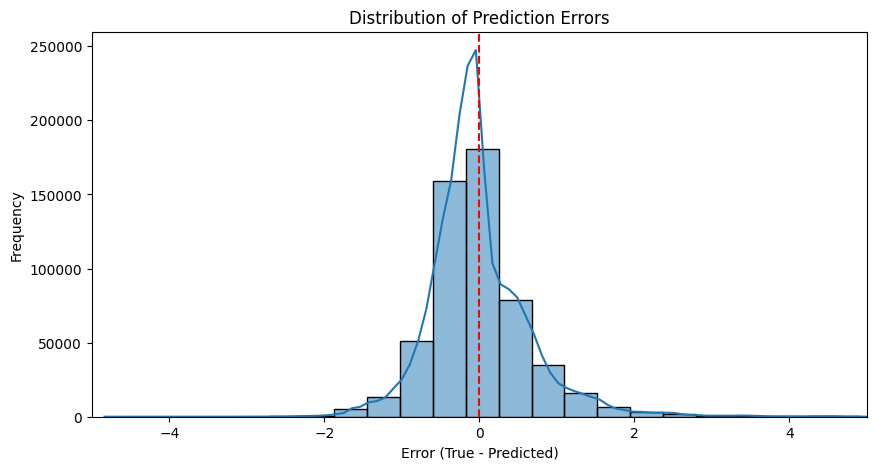

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

errors = y_validation - y_pred_final

plt.figure(figsize=(10,5))
sns.histplot(errors, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Error (True - Predicted)")
plt.xlim(-5,5)
plt.ylabel("Frequency")
plt.show()

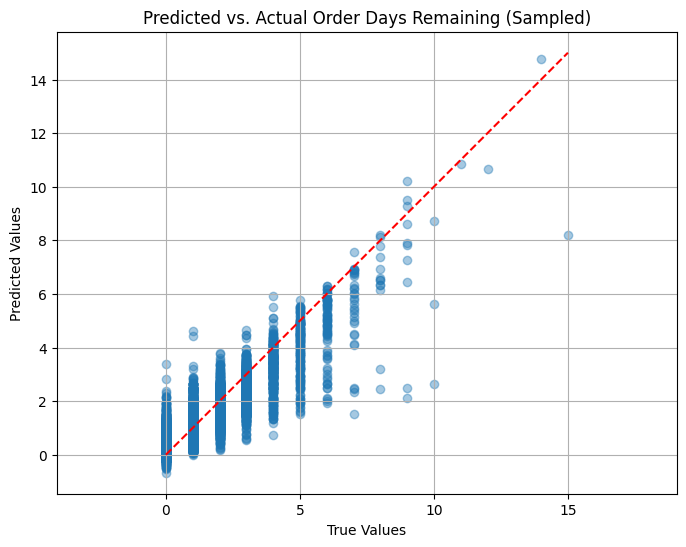

In [84]:
df_plot = pd.DataFrame({'y_true': y_validation, 'y_pred': y_pred_final}).sample(n=10000, random_state=42)

plt.figure(figsize=(8,6))
plt.scatter(df_plot['y_true'], df_plot['y_pred'], alpha=0.4)
plt.plot([df_plot['y_true'].min(), df_plot['y_true'].max()], 
         [df_plot['y_true'].min(), df_plot['y_true'].max()], 
         'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Actual Order Days Remaining (Sampled)")
plt.axis('equal')
plt.grid()
plt.show()


#### predict final

In [87]:
X_train_predict_final = df_train_final_pd.drop(columns=['has_order', 'order_days_remaining']) 
y_train_predict_final = df_train_final_pd['order_days_remaining'] 

final_model = LGBMRegressor(**params_best, n_estimators=500)
final_model.fit(X_train_predict_final.drop(columns=ignore_cols), y_train_predict_final)

LGBMRegressor(colsample_bytree=0.8620216103711961,
              learning_rate=0.19774785103891163, max_depth=19,
              min_child_samples=41, n_estimators=500, num_leaves=254,
              reg_alpha=2.1206906033579413e-05, reg_lambda=0.005611577804405253,
              subsample=0.6552035577604718)

In [90]:
X_prediction = df_predict_pd.drop(columns=['has_order', 'order_days_remaining']) 

In [94]:
X_prediction['prediction_raw'] = final_model.predict( X_prediction.drop(columns=ignore_cols) )

In [96]:
X_prediction['prediction_raw']

0        3.097568
1        2.287611
2        2.245436
3        0.275874
4        0.788877
           ...   
32939    2.198552
32940    2.649560
32941    1.629258
32942    2.760740
32943    3.814297
Name: prediction_raw, Length: 32944, dtype: float64

In [99]:
import numpy as np 
X_prediction['prediction'] = np.round(X_prediction['prediction_raw'])

In [100]:
df_final = X_prediction[['account_id','prediction']]
df_final

,account_id,prediction
0,BR_00003686108,3.0
1,BR_00025293788,2.0
2,BR_00040707393,2.0
3,BR_00057040222,0.0
4,BR_00061294128,1.0
...,...,...
32939,BR_99479532700,2.0
32940,BR_99791803315,3.0
32941,BR_99817705234,2.0
32942,BR_99866706320,3.0


In [102]:
df_final.to_csv('order_days_prediction.csv', index=False)

## Questions 2 

The number of order days per user in a month is a discrete count variable. An approximation may be the Poisson distribution. This assumes that orders occur independently over time with a constant average rate.

The parameter λ can be estimated using the sample mean of order days across all users

-  Given the formula/density function, propose a simple way to calculate the probability of having more than 4 days of orders.

In [104]:
"""To calculate the probability of having more than 4 order days in a month, we use the Poisson cumulative distribution function (CDF).
The formula is:
P(X > 4) = 1 − P(X ≤ 4) = 1 − poisson.cdf(4, λ)
In this example, assuming λ = 2.5, the probability is approximately 1 - poisson.cdf(4, mu=2.5)."""

from scipy.stats import poisson

lambda_ = 2.5  # example
prob = 1 - poisson.cdf(4, mu=lambda_)
prob

np.float64(0.10882198108584873)

Model time between orders with an Exponential distribution. Estimate lambda as the inverse of the mean inter-arrival time.